# Optimization for Statistical Learning Part 2 - Experiment Notebook #

## Section 0 Environment Setup ##

In this section, libraries, datasets and associative python programme are imported, as well as the setup of the experiment environment.

### Section 0.1 Packages and Libraries ###

**Packages Installation**

In [1]:
#!pip install jupyter
#!pip install numpy
#!pip install torch torchvision 
#!pip install matplotlib
#!pip install pandas
#!pip install tensorflow
#!pip install torch
#!pip install torchvision
#!pip install torch_xla
#!pip install torch-neuron --extra-index-url=https://pip.repos.neuron.amazonaws.com/
#!pip install pytorch torchvision cudatoolkit=9.0 -c pytorch

**Importing Libraries**

In [2]:
import math
import statistics
import random
import string
import timeit
from datetime import datetime
import matplotlib.pyplot as plt
import unicodedata
import os
import csv
import pandas as pd
import numpy as np
import torch
from torch.utils.data import random_split, Dataset, DataLoader
from torch.optim.optimizer import (Optimizer, required, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc)
import torchvision.transforms as transforms

**Importing Python Programme**

Here is the section for importing external python files.

### Section 0.1 Set up Experiment Environment ###

**Utilize GPU**

For local environments, please utilize the GPU to speed up the training time.

In [3]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_device()

**Utililze TPU**

To shorten the training time, we highly recommend that experiments should be done in Google Colab. Enable the following code in the Google Colab platform.

In [ ]:
## Assume that you are on the Google Colab platform.
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()

def to_device(data, device):
    data.to(device)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

### Section 0.2 Datasets ##

#### Section 0.2.0 Preprocessing Functions ####
Here are the functions for preprocessing the data.

In [4]:
global current_dataset_name
global current_method_name

def normalize_tensor(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor

##############################
# Text Dataset Preprocessing #
##############################
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#### Section 0.2.1 Importing Datasets from Packages ####
This will load the dataset automatically downloaded from the package. Remember the datasets will be stored in the folder "Datasets".

**MINST Dataset**

In [4]:
from torchvision.datasets import MNIST

# Download Dataset
MNIST_train_dataset = MNIST(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
MNIST_test_dataset = MNIST(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000


=== Raw Data Samples from the MNIST Train Dataset ===


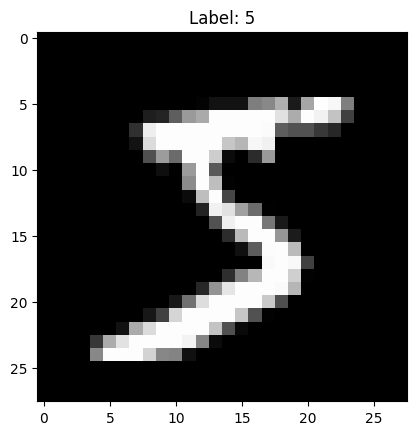

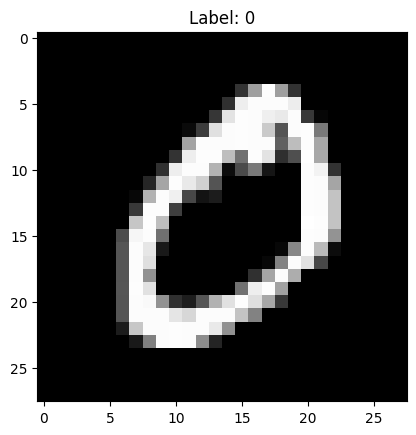

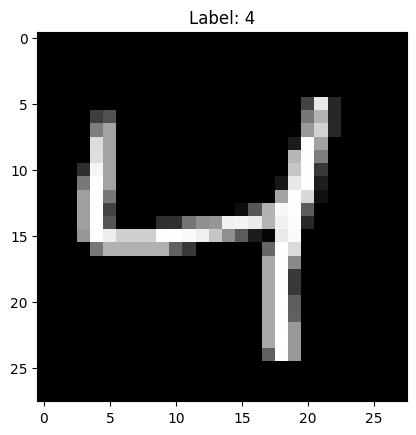

=== Raw Data Samples from the MNIST Test Dataset ===


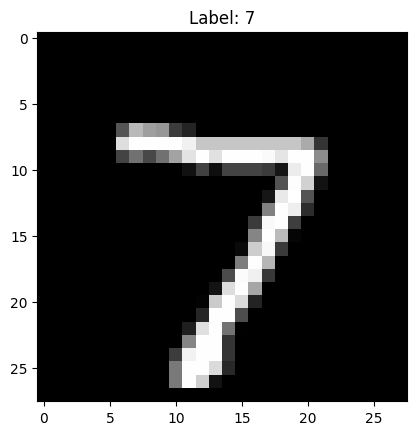

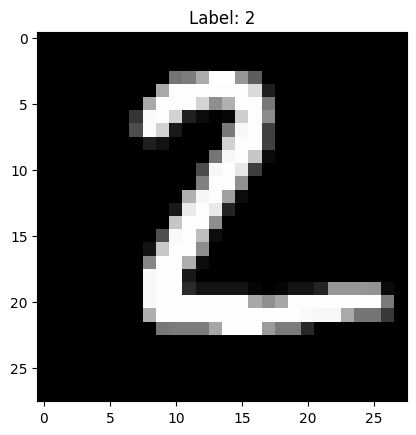

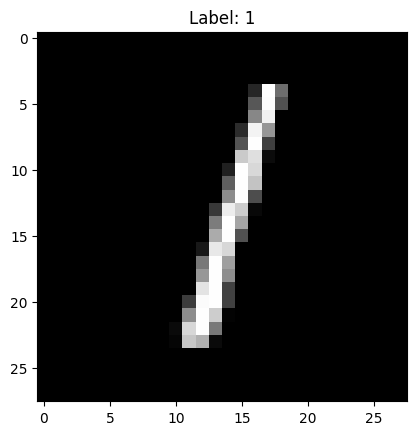

In [6]:
# Visualize the raw data from the dataset
print("=== Raw Data Samples from the MNIST Train Dataset ===")
for i in range(3):
    image, label = MNIST_train_dataset[i]
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

print("=== Raw Data Samples from the MNIST Test Dataset ===")
for i in range(3):
    image, label = MNIST_test_dataset[i]
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

**CIFAR-10 Dataset**

In [ ]:
from torchvision.datasets import CIFAR10

# Download Dataset
CIFAR10_train_dataset = CIFAR10(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
CIFAR10_test_dataset = CIFAR10(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

# Load Dataset
train_dataset = CIFAR10_train_dataset
test_dataset = CIFAR10_test_dataset

# Show Dataset Status
current_dataset_name = "CIFAR10"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

In [ ]:
# Visualize the raw data from the CIFAR10 train dataset
print("=== Raw Data Samples from the CIFAR10 Train Dataset ===")
for i in range(3):
    image, label = CIFAR10_train_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()

# Visualize the raw data from the CIFAR10 test dataset
print("=== Raw Data Samples from the CIFAR10 Test Dataset ===")
for i in range(3):
    image, label = CIFAR10_test_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()

#### Section 0.2.2 Importing Datasets from Downloaded Files ####
This will load the dataset downloaded in the local directories.

**Give Me Some Credit Dataset**

The source of this dataset comes from https://www.kaggle.com/c/GiveMeSomeCredit

Note: This dataset is borrowed from the datasets used in the competitive task in FTEC2101 Optimization Methods.

In [ ]:
# Define Dataset Structure
class Give_Me_Some_Credit_Dataset_Class(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self._load_data()

    def _load_data(self):
        data_frame = pd.read_csv(self.root)
        data = []
        targets = []

        for _, row in data_frame.iterrows():
            features = row.iloc[:-1].values.astype(np.float32)
            label = row.iloc[-1]
            data.append(features)
            targets.append(float(int(label)))
        
        data = torch.tensor(data)
        targets = torch.tensor(targets)
        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            features = self.transform(features)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label

# Load Dataset
Give_Me_Some_Credit_train_dataset = Give_Me_Some_Credit_Dataset_Class(root='./Datasets/Give_Me_Some_Credit/ftec-cs-full-train.csv', train=True, transform=normalize_tensor)
Give_Me_Some_Credit_test_dataset = Give_Me_Some_Credit_Dataset_Class(root='./Datasets/Give_Me_Some_Credit/ftec-cs-full-test.csv', train=False, transform=normalize_tensor)

train_dataset = Give_Me_Some_Credit_train_dataset
test_dataset = Give_Me_Some_Credit_test_dataset

# Show Dataset Status
current_dataset_name = "Give Me Some Credit Dataset"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

**Epsilon Dataset**

Note: This dataset is best suited for binary classification. The training dataset contains 400000 objects. Each object is described by 2001 columns. The first column contains the label value, all other columns contain numerical features. The validation dataset contains 100000 objects. The structure is identical to the training dataset.

Warning: The loading time for this dataset is too long.

In [ ]:
# Define Dataset Structure
class EpsilonDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self._load_data()
    
    def process_line(self, line):
        line = line.split(' ')
        label, values = int(line[0]), line[1:]
        value = torch.zeros(line[1:].size())
        for item in values:
            idx, val = item.split(':')
            value[int(idx) - 1] = float(val)
        return label, value

    def _load_data(self):
        data_frame = pd.read_csv(self.root, nrows=20000)
        data = []
        targets = []

        with open(self.root, 'r') as fp:
            for line in fp:
                label, value = self.process_line(line.strip("\n"))
                data.append(value)
                targets.append(label)

        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            features = self.transform(features)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label

# Load Dataset
Epsilon_train_dataset = EpsilonDataset(root='./Datasets/epsilon/epsilon_normalized', train=True, transform=None)
Epsilon_test_dataset = EpsilonDataset(root='./Datasets/epsilon/epsilon_normalized.t', train=False, transform=None)

train_dataset = Epsilon_train_dataset
test_dataset = Epsilon_test_dataset

# Show Dataset Status
current_dataset_name = "Epsilon"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

**Languages Dataset**

The dataset is downloaded from here: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [ ]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('Datasets/Language_dataset/names/*.txt'))

# Build the category_lines dictionary, a list of names per language
languages_dataset_category_lines = {}
languages_dataset_all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('Datasets/Language_dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages_dataset_all_categories.append(category)
    lines = readLines(filename)
    languages_dataset_category_lines[category] = lines

n_categories = len(languages_dataset_all_categories)

class LanguageDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self._load_data()

    def _load_data(self):
        data_frame = pd.read_csv(self.root, nrows=20000)
        data = []
        targets = []

        with open(self.root, 'r') as fp:
            for line in fp:
                label, value = self.process_line(line.strip("\n"))
                data.append(value)
                targets.append(label)

        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            features = self.transform(features)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label

Languages_train_dataset = LanguageDataset(root='./Datasets/epsilon/epsilon_normalized', train=True, transform=None)

## Section 1 Classes, Functions and Algorithms ##
All common and helping functions for machine learning tasks are defined here.

In [78]:
############################
#     Helping Functions    #
############################
# Random Seed Function
# To ensure a same training result under the random process, you might need to set the random seed via this function.
def set_random_seed(custom_random_seed):
    torch.manual_seed(custom_random_seed)
    random.seed(custom_random_seed)
    np.random.seed(custom_random_seed)

# Convert anything into a list if input is not a list
def convert_to_list(input_list):
    if not isinstance(input_list, list):
        input_list = [input_list]
    return input_list

# Graph Plotting Functions
def plot_cost_history(cost_history_list=[], save=True, x_label_name="Epochs", y_label_name="Cost", title_name="Culminative Send Cost History"):
    cost_history_list = convert_to_list(cost_history_list)
    for i, cost_history in enumerate(cost_history_list):
        plt.plot(cost_history, label=f"Cost History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(cost_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_culminative_send_cost_history_{train_start_time}.png')
    plt.show()

def plot_time_history(time_history_list=[], save=True, x_label_name="Epochs", y_label_name="Culminative Time Used", title_name="Time History"):
    time_history_list = convert_to_list(time_history_list)
    for i, time_history in enumerate(time_history_list):
        plt.plot(time_history, label=f"Time History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(time_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_time_history_{train_start_time}.png')
    plt.show()

def plot_loss_history(train_loss_history_list=[], test_loss_history_list=[], save=True, x_label_name="Epochs", y_label_name="Loss", title_name="Loss History"):
    train_loss_history_list = convert_to_list(train_loss_history_list)
    test_loss_history_list = convert_to_list(test_loss_history_list)
    for i, train_loss_history in enumerate(train_loss_history_list):
        plt.plot(train_loss_history, label=f"Train Loss History {i+1}")
    for i, test_loss_history in enumerate(test_loss_history_list):
        plt.plot(test_loss_history, label=f"Test Loss History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_loss_history_list) + len(test_loss_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_loss_history_{train_start_time}.png')
    plt.show()

def plot_accuracy_history(train_accuracy_history_list=[], test_accuracy_history_list=[], save=True, x_label_name="Epochs", y_label_name="Accuracy", title_name="Accuracy History"):
    train_accuracy_history_list = convert_to_list(train_accuracy_history_list)
    test_accuracy_history_list = convert_to_list(test_accuracy_history_list)
    for i, train_accuracy_history in enumerate(train_accuracy_history_list):
        plt.plot(train_accuracy_history, label=f"Train Accuracy History {i+1}")
    for i, test_accuracy_history in enumerate(test_accuracy_history_list):
        plt.plot(test_accuracy_history, label=f"Test Accuracy History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_accuracy_history_list) + len(test_accuracy_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_accuracy_history_{train_start_time}.png')
    plt.show()

def plot_error_history(train_error_history_list=[], test_error_history_list=[], save=True, x_label_name="Epochs", y_label_name="Error", title_name="Error History"):
    train_error_history_list = convert_to_list(train_error_history_list)
    test_error_history_list = convert_to_list(test_error_history_list)
    for i, train_error_history in enumerate(train_error_history_list):
        plt.plot(train_error_history, label=f"Train Error History {i+1}")
    for i, test_error_history in enumerate(test_error_history_list):
        plt.plot(test_error_history, label=f"Test Error History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_error_history_list) + len(test_error_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_error_history_{train_start_time}.png')
    plt.show()

# Accuracy and Error Rate Calculation
def get_accuracy(outputs, labels):
    with torch.no_grad():
        if outputs.dim() > 1:
            _, predictions = torch.max(outputs, dim=1)
        else:
            predictions = outputs
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

def get_error(outputs, labels):
    with torch.no_grad():
        if outputs.dim() > 1:
            _, predictions = torch.max(outputs, dim=1)
        else:
            predictions = outputs
        return torch.tensor(torch.sum(predictions != labels).item() / len(predictions))

def straggler_rate(num_client, percentage = 1.00):
    return max(round(num_client * percentage), 1)

############################
#  Custom Loss Functions   #
############################



############################
#     Custom Optimizer     #
############################
class optimizer(Optimizer):
    def __init__(self, params, lr=required, weight_decay=0 ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)
                
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                weight_decay = group['weight_decay']
                lr = group['lr']
                param.data.add_(-lr, grad)
                if weight_decay != 0:
                    param.data.add_(-lr * weight_decay, param.data)

############################
#   Neural Network Model   #
############################
global Linear_Model_in_features
global Linear_Model_out_features
class Linear_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(in_features=Linear_Model_in_features, out_features=Linear_Model_out_features)
    
    def forward(self, x):
        x = self.linear(x)
        return torch.squeeze(x)

class MNIST_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return torch.squeeze(x)

class CIFAR10_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            torch.nn.BatchNorm2d(256),

            torch.nn.Flatten(), 
            torch.nn.Linear(256*4*4, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.activation_stack(x)
        return torch.squeeze(x)

class RNN_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_stack = torch.nn.Sequential(
            torch.nn.RNN()
        )

############################
#    Iterate Algorithm     #
############################
def evaluate_model_simple(model, dataloader, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    losses = []
    accuracies = []
    errors = []
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
    return loss_average, accuracy_average, error_average

def iterate_model_simple(model, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, test_dataloader=None):
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = []
    start_time = timeit.default_timer()

    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average:.16f}, Average Accuracy: {accuracy_average:.16f}, Average Error: {error_average:.16f}, Culminative Time Used: {time_used}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')
    if test_dataloader is not None:
        return loss_history, accuracy_history, error_history, time_history, test_loss_history, test_accuracy_history, test_error_history
    return loss_history, accuracy_history, error_history, time_history

############################
#      Client Devices      #
############################
# Define a custom class for each client so they can update separately
class ClientDevice:
    def __init__(self, client_id, model, optimizer, dataset, batch_size, iterate_func, loss_func, accuracy_func=get_accuracy, error_func=get_error):
        self.id = client_id
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.iterate_func = iterate_func
        self.loss_func = loss_func
        self.accuracy_func = accuracy_func
        self.error_func = error_func

    def load_weights(self, weights):
        self.model.load_state_dict(weights)

    def get_local_weights(self):
        return self.model.state_dict()
    
    def get_client_id(self):
        return self.id
    
    def get_dataset_size(self):
        return len(self.dataset)

    def save_local_history(self, num_epochs, loss_history, accuracy_history, error_history, time_history, value=train_start_time):
        filename = "{}_client_{}_with_local_epochs_{}_local_loss_accuracy_error_history_{}.npy".format(current_dataset_name, self.id, num_epochs, value)
        with open(filename, 'wb') as f:
            np.savez(f, loss_history=loss_history, accuracy_history=accuracy_history, error_history=error_history, time_history=time_history)

    def train(self, num_epochs, show_history=False):
        if show_history:
            print(f"!-- Client {self.id} start iterations. ---!")
        loss_history, accuracy_history, error_history, time_history = self.iterate_func(self.model, self.dataloader, num_epochs, self.optimizer, self.loss_func, self.accuracy_func, self.error_func)
        if show_history:
            plot_time_history(time_history)
            plot_loss_history(loss_history)
            plot_accuracy_history(accuracy_history)
            plot_error_history(error_history)
            print(f"!-- Client {self.id} finish iterations. ---!")
        return self.model.state_dict()

# Distribute the training datasets to clients, remember it returns an array of datasets
def split_datasets_for_clients_random(dataset, num_clients=1):
    total_sample_size = len(dataset)
    samples_per_clients = total_sample_size // num_clients
    client_datasets = random_split(dataset, [min(i + samples_per_clients, total_sample_size) - i for i in range(0, total_sample_size, samples_per_clients)])
    return client_datasets

# Be careful where the label placed and remember to modify the sample[1] if necessary
# Not correct
def split_datasets_by_label(dataset, num_labels=10):
    sorted_by_value = [0] * num_labels
    for i in range(num_labels):
        sorted_by_value[i] =(dataset.data[np.where(np.array(dataset.targets) == i)])
        np.random.shuffle(sorted_by_value[i])
    return sorted_by_value

def split_datasets_for_clients_label(dataset, num_clients=1, num_labels=10):
    total_sample_size = len(dataset)
    samples_per_client = total_sample_size // num_clients
    remaining_samples = total_sample_size % num_clients

    # Determine labels for each client
    labels_per_client = num_labels // num_clients
    client_labels = [list(range(i * labels_per_client, (i + 1) * labels_per_client + 1)) for i in range(num_clients)]
    remaining_labels = list(range(num_clients * labels_per_client, num_labels))
    for client_id in range(num_clients):
        client_labels[client_id].extend(remaining_labels[:client_id])

    # Filter samples for each client
    client_datasets = []
    for client_id in range(num_clients):
        labels = client_labels[client_id]
        filtered_dataset = [sample for sample in dataset if dataset.targets in labels]

        # Adjust the length of the dataset for the last client to include remaining samples
        client_samples = samples_per_client + (remaining_samples if client_id == num_clients - 1 else 0)

        client_dataset = random_split(filtered_dataset, [client_samples] * num_clients)
        client_datasets.append(client_dataset)

    return client_datasets

# Establish client devices
def establish_client_devices(num_clients, model_list, optimizer_list, dataset_list, batch_size_list, iterate_func_list, loss_func_list, accuracy_func_list, error_func_list):
    client_device = [None] * num_clients
    for client_id in range(num_clients):
        client_device[client_id] = ClientDevice(client_id, model_list[client_id], optimizer_list[client_id], dataset_list[client_id], batch_size_list[client_id], iterate_func_list[client_id], loss_func_list[client_id], accuracy_func_list[client_id], error_func_list[client_id])
    return client_device

#########################################
#     Federated Learning Algorithms     #
#########################################
def federated_averaging(client_weights_total):
    total_clients = len(client_weights_total)
    aggregate_weights = {}

    # Initialize aggregate_weights with the first client's weights
    for layer_name, layer_weights in client_weights_total[0].items():
        aggregate_weights[layer_name] = layer_weights / total_clients

    # Aggregate weights from the remaining clients
    for client_weights in client_weights_total[1:]:
        for layer_name, layer_weights in client_weights.items():
            aggregate_weights[layer_name] += layer_weights / total_clients

    return aggregate_weights

def iterate_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, global_epochs, local_epochs, straggler=1, aggregate_func=federated_averaging, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, random_local_epoch=False, show_history=True):
    cost_history = []
    time_history = []
    start_time = timeit.default_timer()
    send_cost = 0.00

    train_loss_history = []
    train_accuracy_history = []
    train_error_history = []
    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []

    for epoch in range(global_epochs):
        global_weights = global_model.state_dict()
        client_weights_total = []
        random_client_list = random.sample(client_list, straggler)
        for client in random_client_list:
            client.load_weights(global_weights)
            if random_local_epoch is True:
                client_weights = client.train(num_epochs=random.randint(1, local_epochs))
            else:
                client_weights = client.train(num_epochs=local_epochs)
            client_weights_total.append(client_weights)
            send_cost += sum(value.numel() for value in client_weights.values())
        global_weights.update(aggregate_func(client_weights_total))
        global_model.load_state_dict(global_weights)

        # Record
        time_used = timeit.default_timer() - start_time
        cost_history.append(send_cost)
        time_history.append(time_used)

        train_loss, train_accuracy, train_error = evaluate_model_simple(model=global_model, dataloader=train_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        train_error_history.append(train_error)

        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=global_model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)

        if show_history:
            print(f'Epoch [{epoch+1}/{global_epochs}], Culminative Send Cost: {send_cost}, Culminative Time Used: {time_used}')
            print(f'Train Loss: {train_loss:.16f}, Train Accuracy: {train_accuracy:.16f}, Train Error: {train_error:.16f}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')

    return cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

#################################
#  FedProx Framework Algorithm  #
#################################
def iterate_model_FedProx(model, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True):
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = []
    start_time = timeit.default_timer()
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            #proximal_term = 0.0
            #for w, w_t in zip(model.parameters(), FedProx_global_model.parameters()):
            #    proximal_term += (w - w_t).norm(2)
            proximal_term = torch.norm(torch.cat([w.flatten() - w_t.flatten() for w, w_t in zip(model.parameters(), FedProx_global_model.parameters())]), p=2)
            loss = loss_func(outputs, labels) + (FedProx_mu / 2) * (proximal_term ** 2)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average:.16f}, Average Accuracy: {accuracy_average:.16f}, Average Error: {error_average:.16f}, Culminative Time Used: {time_used}')
    return loss_history, accuracy_history, error_history, time_history

############################
#    Training Algorithm    #
############################
def train_neural_network_model(model, train_dataloader, test_dataloader, num_epochs, optimizer, learning_rate, batch_size, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, save_result=True):
    if test_dataloader is not None:
        train_loss_history, train_accuracy_history, train_error_history, time_history, test_loss_history, test_accuracy_history, test_error_history = iterate_model_simple(model, train_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history, test_dataloader)
    else:
        train_loss_history, train_accuracy_history, train_error_history, time_history = iterate_model_simple(model, train_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history)

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_train_NN_with_num_epochs_{}_batch_size_{}_lr_{}_{}_{}.npy".format(current_dataset_name, num_epochs, batch_size, learning_rate, train_start_time, experiment_id)
        with open(filename, 'wb') as f:
            np.savez(f, time_history=time_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history)
        torch.save(model.state_dict(), filename + "_model_state_dict.pth")

    # Graph
    if show_history:
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
    
    return time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def train_federated_learning_model(global_model, train_dataloader, test_dataloader, global_epochs, local_epochs, client_list, batch_size, straggler, aggregate_func=federated_averaging, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, random_local_epoch=False, show_history=True, save_result=True):
    cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = iterate_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, global_epochs, local_epochs, straggler, aggregate_func, loss_func, accuracy_func, error_func, random_local_epoch, show_history)

    # Print learned parameters
    for name, param in global_model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_{}_with_global_epochs_{}_local_epochs_{}_num_clients_{}_batch_size_{}_{}_{}.npy".format(current_dataset_name, current_method_name, global_epochs, local_epochs, len(client_list), batch_size, train_start_time, experiment_id)
        with open(filename, 'wb') as f:
            np.savez(f, cost_history=cost_history, time_history=time_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history)
        torch.save(global_model.state_dict(), filename + "_model_state_dict.pth")

    # Graph
    if show_history:
        plot_cost_history([cost_history])
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
    
    return cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

############################
#   Experiment Functions   #
############################
def experiment_neural_network_model(train_dataset, test_dataset, modelClass, optimizerClass, train_func, epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, compare_id = 0, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    epochs_list = convert_to_list(epochs_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)

    local_epochs_list_size = len(epochs_list)
    learning_rate_list_size = len(learning_rate_list)
    batch_size_list_size = len(batch_size_list)
    loss_func_list_size = len(loss_func_list)
    accuracy_func_list_size = len(accuracy_func_list)
    error_func_list_size = len(error_func_list)

    time_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []

    if compare_id == 2:
        iteration_list = learning_rate_list
    elif compare_id == 3:
        iteration_list = batch_size_list
    elif compare_id == 4:
        iteration_list = loss_func_list
    elif compare_id == 5:
        iteration_list = accuracy_func_list
    elif compare_id == 6:
        iteration_list = error_func_list
    else:
        iteration_list = epochs_list
    
    for n in range(len(iteration_list)):
        experiment_id = experiment_id + 1
        if compare_id == 2:
            print(f'=== The training for learning_rate_list is {learning_rate_list[n]} ===')
            num_epochs = epochs_list[0]
            learning_rate = learning_rate_list[n]
            batch_size = batch_size_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 3:
            print(f'=== The training for batch_size_list is {batch_size_list[n]} ===')
            num_epochs = epochs_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[n]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 4:
            print(f'=== The training for loss function is {loss_func_list[n].__name__} ===')
            num_epochs = epochs_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            loss_func = loss_func_list[n]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 5:
            print(f'=== The training for accuracy function is {accuracy_func_list[n].__name__} ===')
            num_epochs = epochs_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[n]
            error_func = error_func_list[0]
        elif compare_id == 6:
            print(f'=== The training for error function is {error_func_list[n].__name__} ===')
            num_epochs = epochs_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[n]
        else:
            print(f'=== The training for num_epochs is {epochs_list[n]} ===')
            num_epochs = epochs_list[n]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[n]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        
        model = to_device(modelClass(), device)
        print(model)
        print(model.state_dict())

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        optimizer = optimizerClass(model.parameters(), learning_rate)

        time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_func(model, train_dataloader, test_dataloader, num_epochs, optimizer, learning_rate, batch_size, loss_func, accuracy_func, error_func, show_history, save_result)

        time_history_total.append(time_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)

def experiment_FedAvg_model(train_dataset, test_dataset, modelClass, optimizerClass, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, random_local_epoch=False, compare_id = 0, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    global_epochs_list = convert_to_list(global_epochs_list)
    local_epochs_list = convert_to_list(local_epochs_list)
    num_clients_list = convert_to_list(num_clients_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    straggler_list = convert_to_list(straggler_list)
    aggregate_func_list = convert_to_list(aggregate_func_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)

    global_epochs_list_size = len(global_epochs_list)
    local_epochs_list_size = len(local_epochs_list)
    num_clients_list_size = len(num_clients_list)
    learning_rate_list_size = len(learning_rate_list)
    batch_size_list_size = len(batch_size_list)
    straggler_list_size = convert_to_list(straggler_list)
    aggregate_func_list_size = len(aggregate_func_list)
    loss_func_list_size = len(loss_func_list)
    accuracy_func_list_size = len(accuracy_func_list)
    error_func_list_size = len(error_func_list)

    cost_history_total = []
    time_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []

    if compare_id == 2:
        iteration_list = local_epochs_list
    elif compare_id == 3:
        iteration_list = num_clients_list
    elif compare_id == 4:
        iteration_list = learning_rate_list
    elif compare_id == 5:
        iteration_list = batch_size_list
    elif compare_id == 6:
        iteration_list = straggler_list
    elif compare_id == 7:
        iteration_list = aggregate_func_list
    elif compare_id == 8:
        iteration_list = loss_func_list
    elif compare_id == 9:
        iteration_list = accuracy_func_list
    elif compare_id == 10:
        iteration_list = error_func_list
    else:
        iteration_list = global_epochs_list
    
    for n in range(len(iteration_list)):
        experiment_id = experiment_id + 1
        if compare_id == 2:
            print(f'=== The training for local_epochs is {local_epochs_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[n]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 3:
            print(f'=== The training for num_clients is {num_clients_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[n]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 4:
            print(f'=== The training for learning_rate_list is {learning_rate_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[n]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 5:
            print(f'=== The training for batch_size_list is {batch_size_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[n]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 6:
            print(f'=== The training for straggler_list is {straggler_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[n]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 7:
            print(f'=== The training for aggregate function is {aggregate_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[n]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 8:
            print(f'=== The training for loss function is {loss_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[n]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        elif compare_id == 9:
            print(f'=== The training for accuracy function is {accuracy_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[n]
            error_func = error_func_list[0]
        elif compare_id == 10:
            print(f'=== The training for error function is {error_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[n]
        else:
            print(f'=== The training for global_epochs is {global_epochs_list[n]} ===')
            global_epochs = global_epochs_list[n]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        
        global_model = to_device(modelClass(), device)
        print(global_model)
        print(global_model.state_dict())

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        client_model_list = [to_device(modelClass(), device)] * num_clients
        client_optimizer_list = [optimizerClass(model.parameters(), learning_rate) for model in client_model_list]
        client_dataset_list = split_datasets_for_clients_random(train_dataset, num_clients)
        client_batch_size_list = [batch_size] * num_clients
        client_itera_func_list = [itera_func] * num_clients
        client_loss_func_list = [loss_func] * num_clients
        client_accuracy_func_list = [accuracy_func] * num_clients
        client_error_func_list = [error_func] * num_clients
        client_list = establish_client_devices(num_clients, client_model_list, client_optimizer_list, client_dataset_list, client_batch_size_list, client_itera_func_list, client_loss_func_list, client_accuracy_func_list, client_error_func_list)

        cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_federated_learning_model(global_model, train_dataloader, test_dataloader, global_epochs, local_epochs, client_list, batch_size, straggler, aggregate_func, loss_func, accuracy_func, error_func, random_local_epoch, show_history, save_result)

        cost_history_total.append(cost_history)
        time_history_total.append(time_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_cost_history(cost_history_total)
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)

def experiment_FedProx_model(train_dataset, test_dataset, modelClass, optimizerClass, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, mu_list, random_local_epoch=False, compare_id = 0, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    global_epochs_list = convert_to_list(global_epochs_list)
    local_epochs_list = convert_to_list(local_epochs_list)
    num_clients_list = convert_to_list(num_clients_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    straggler_list = convert_to_list(straggler_list)
    aggregate_func_list = convert_to_list(aggregate_func_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)
    mu_list = convert_to_list(mu_list)

    global_epochs_list_size = len(global_epochs_list)
    local_epochs_list_size = len(local_epochs_list)
    num_clients_list_size = len(num_clients_list)
    learning_rate_list_size = len(learning_rate_list)
    batch_size_list_size = len(batch_size_list)
    straggler_list_size = convert_to_list(straggler_list)
    aggregate_func_list_size = len(aggregate_func_list)
    loss_func_list_size = len(loss_func_list)
    accuracy_func_list_size = len(accuracy_func_list)
    error_func_list_size = len(error_func_list)
    mu_func_list_size = len(mu_list)

    global FedProx_global_model
    global FedProx_mu

    cost_history_total = []
    time_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []

    if compare_id == 2:
        iteration_list = local_epochs_list
    elif compare_id == 3:
        iteration_list = num_clients_list
    elif compare_id == 4:
        iteration_list = learning_rate_list
    elif compare_id == 5:
        iteration_list = batch_size_list
    elif compare_id == 6:
        iteration_list = straggler_list
    elif compare_id == 7:
        iteration_list = aggregate_func_list
    elif compare_id == 8:
        iteration_list = loss_func_list
    elif compare_id == 9:
        iteration_list = accuracy_func_list
    elif compare_id == 10:
        iteration_list = error_func_list
    elif compare_id == 11:
        iteration_list = mu_list
    else:
        iteration_list = global_epochs_list
    
    for n in range(len(iteration_list)):
        experiment_id = experiment_id + 1
        if compare_id == 2:
            print(f'=== The training for local_epochs is {local_epochs_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[n]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 3:
            print(f'=== The training for num_clients is {num_clients_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[n]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 4:
            print(f'=== The training for learning_rate_list is {learning_rate_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[n]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 5:
            print(f'=== The training for batch_size_list is {batch_size_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[n]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 6:
            print(f'=== The training for straggler_list is {straggler_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[n]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 7:
            print(f'=== The training for aggregate function is {aggregate_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[n]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 8:
            print(f'=== The training for loss function is {loss_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[n]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 9:
            print(f'=== The training for accuracy function is {accuracy_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[n]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[0]
        elif compare_id == 10:
            print(f'=== The training for error function is {error_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[n]
            FedProx_mu = mu_list[0]
        elif compare_id == 11:
            print(f'=== The training for mu is {mu_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
            FedProx_mu = mu_list[n]
        else:
            print(f'=== The training for global_epochs is {global_epochs_list[n]} ===')
            global_epochs = global_epochs_list[n]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            straggler = straggler_list[0]
            aggregate_func = aggregate_func_list[0]
            loss_func = loss_func_list[0]
            accuracy_func = accuracy_func_list[0]
            error_func = error_func_list[0]
        
        global_model = to_device(modelClass(), device)
        print(global_model)
        print(global_model.state_dict())
        FedProx_global_model = global_model

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        client_model_list = [to_device(modelClass(), device)] * num_clients
        client_optimizer_list = [optimizerClass(model.parameters(), learning_rate) for model in client_model_list]
        client_dataset_list = split_datasets_for_clients_random(train_dataset, num_clients)
        client_batch_size_list = [batch_size] * num_clients
        client_itera_func_list = [itera_func] * num_clients
        client_loss_func_list = [loss_func] * num_clients
        client_accuracy_func_list = [accuracy_func] * num_clients
        client_error_func_list = [error_func] * num_clients
        client_list = establish_client_devices(num_clients, client_model_list, client_optimizer_list, client_dataset_list, client_batch_size_list, client_itera_func_list, client_loss_func_list, client_accuracy_func_list, client_error_func_list)

        cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_federated_learning_model(global_model, train_dataloader, test_dataloader, global_epochs, local_epochs, client_list, batch_size, straggler, aggregate_func, loss_func, accuracy_func, error_func, random_local_epoch, show_history, save_result)

        cost_history_total.append(cost_history)
        time_history_total.append(time_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_cost_history(cost_history_total)
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)

## Section 2 Experiment ##

### Section 2.1 Choosing Dataset ###

In this section, execute a cell only to choose a dataset you want do experiment with.

**MNIST Dataset**

In [6]:
# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.1
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.1
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 10
input_dim = 784
model_type_preset = MNIST_CNN_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.functional.cross_entropy

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000
Number of samples in the train dataset after random split: 60000
Number of samples in the test dataset after random split: 10000


**CIFAR10 Dataset**

In [ ]:
# Load Dataset
train_dataset = CIFAR10_train_dataset
test_dataset = CIFAR10_test_dataset

# Show Dataset Status
current_dataset_name = "CIFAR10"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
split_ratio = 0.50
train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
split_ratio = 0.007
test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 10
input_dim = 1024
model_type_preset = CIFAR10_CNN_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.functional.cross_entropy

**Give Me Some Credit Dataset**

In [ ]:
# Load Dataset
train_dataset = Give_Me_Some_Credit_train_dataset
test_dataset = Give_Me_Some_Credit_test_dataset

# Show Dataset Status
current_dataset_name = "Give Me Some Credit Dataset"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.01
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.01
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 7
num_classes_preset = 2

Linear_Model_in_features = 7
Linear_Model_out_features = 1
model_type_preset = Linear_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.MSELoss()

**Epsilon Dataset**

In [ ]:
# Load Dataset
train_dataset = Epsilon_train_dataset
test_dataset = Epsilon_test_dataset

# Show Dataset Status
current_dataset_name = "Epsilon"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
split_ratio = 0.50
train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
split_ratio = 0.007
test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 7
num_classes_preset = 2

model_type_preset = Linear_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.MSELoss()

### Section 2.2 Neural Network Experiments ###

Note that, compare_id represents:

1: compare number of epochs

2: compare learning rate

3: compare batch size

4: compare loss function

5: compare accuracy function

6: compare error function

Others: compare number of epochs

**Experiment: Compare Learning Rate**

The current dataset is MNIST.
The current train start time is 2024-01-14 20.14.17.
=== The training for learning_rate_list is 0.2 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[ 1.8137e-01,  9.3845e-02, -3.1090e-02,  8.8491e-02, -9.5656e-02],
          [-6.0877e-02,  1.5732e-01, -1.3572e-03,  1.9543e-01, -9.6680e-02],
          [ 1.7889e-01, -1.1725e-01,  1.6291e-01, -6.9468e-02, -1.6370e-01],
          [ 6.2807e-02,  1.2960e-01, -1.2133e-02, -7.5775e-02, -1.8824e-01],
          [ 1.5878e-01,  4.8067e-02, -1.0154e-01,  1.6099e-01, -1.3639e-01]]],


     

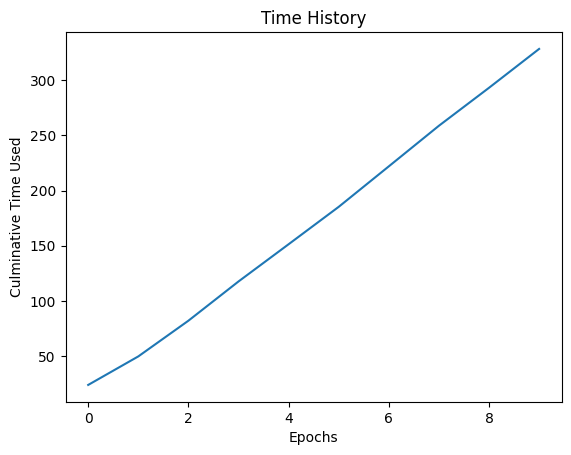

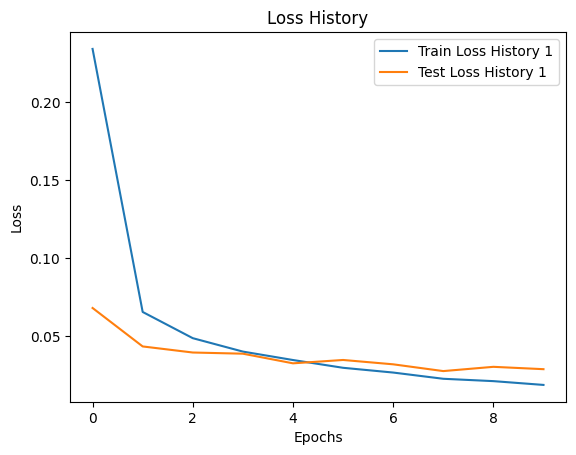

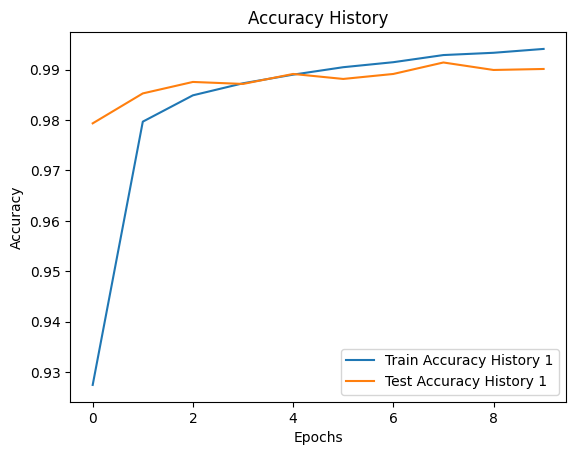

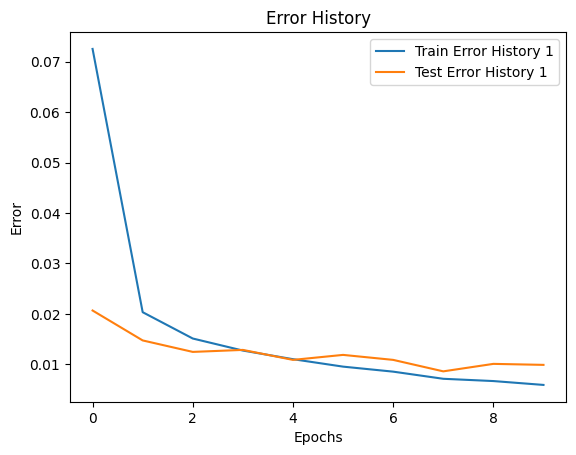

=== The Experiment Result ===
Name of current dataset: MNIST


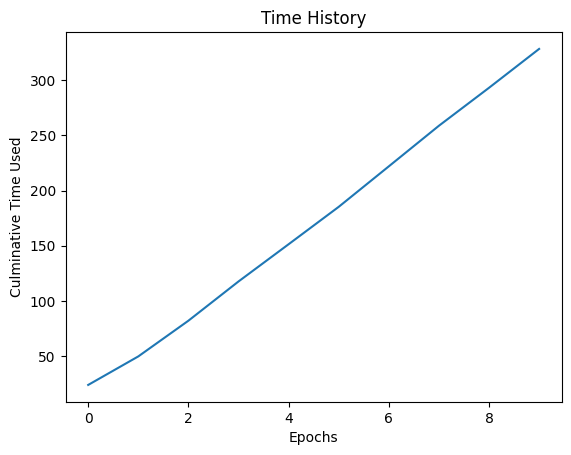

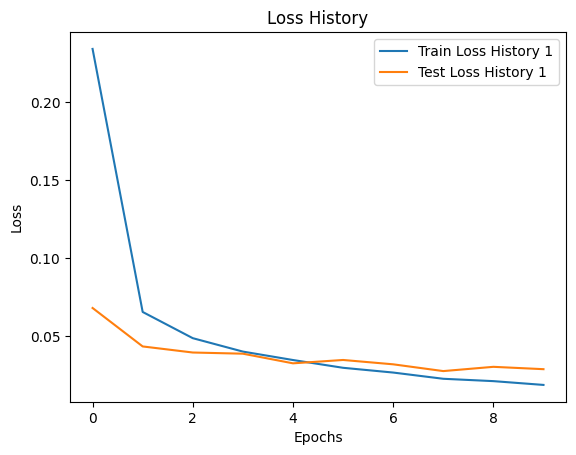

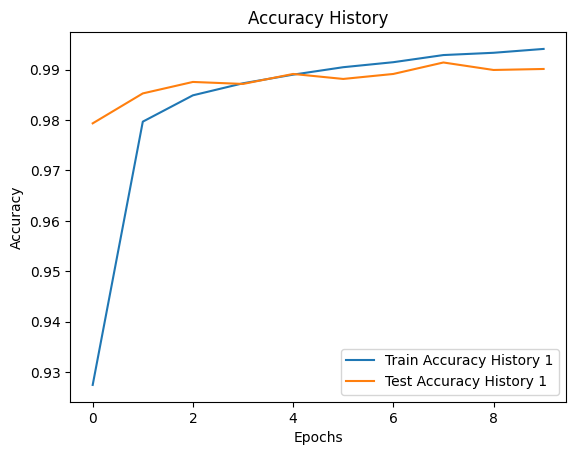

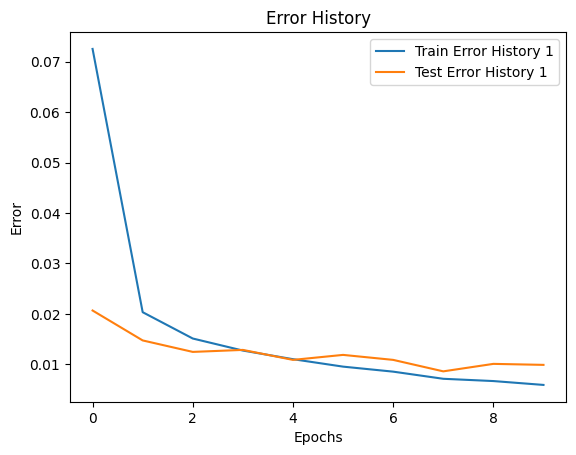

In [17]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
train_func = train_neural_network_model

#Linear_Model_in_features = 28
#Linear_Model_out_features = 10

num_epochs_list = 10
learning_rate_list = 0.2
batch_size_list = 128
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

compare_id = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, compare_id)

**Experiment: Compare Batch Size**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
train_func = train_neural_network_model

num_epochs_list = 25
learning_rate_list = 0.02
batch_size_list = [10, 1000]
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

compare_id = 3

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, compare_id)

### Section 2.3 FedAvg Federated Learning Experiments ###

Note that, compare_id represents:

1: compare global epochs

2: compare local epochs

3: compare number of clients

4: compare learning rate

5: compare batch size

6: compare straggler

7: compare the aggregate weight algorithms

8: compare loss function

9: compare accuracy function

10: compare error function

Others: compare global epochs

**Experiment: Compare Local Update Epochs**

The current dataset is MNIST.
The current train start time is 2024-01-13 20.01.50.
=== The training for local_epochs is 3 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[ 3.7365e-03, -2.4609e-03,  5.5175e-02,  1.7017e-01,  4.8744e-02],
          [-1.5376e-01, -1.2064e-01,  1.1651e-01, -1.1557e-01, -6.2401e-02],
          [-8.5556e-02,  1.3946e-01, -9.2515e-02, -1.4711e-01,  1.2407e-01],
          [ 1.6042e-01, -4.0472e-02,  1.9604e-02, -1.6928e-02,  1.7512e-01],
          [ 1.3381e-01, -7.7318e-02, -4.3596e-02, -3.5490e-02,  1.4606e-01]]],


        [[[-2

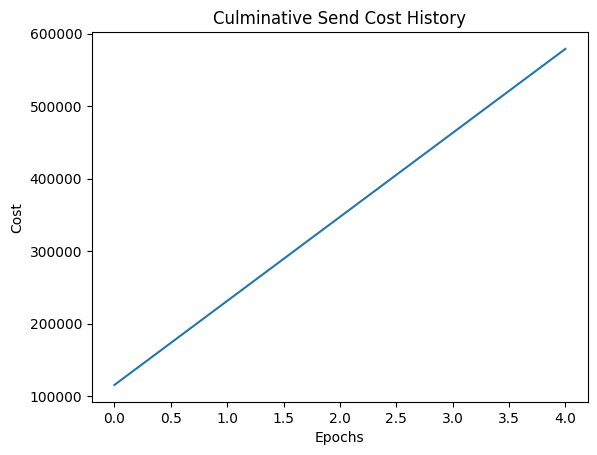

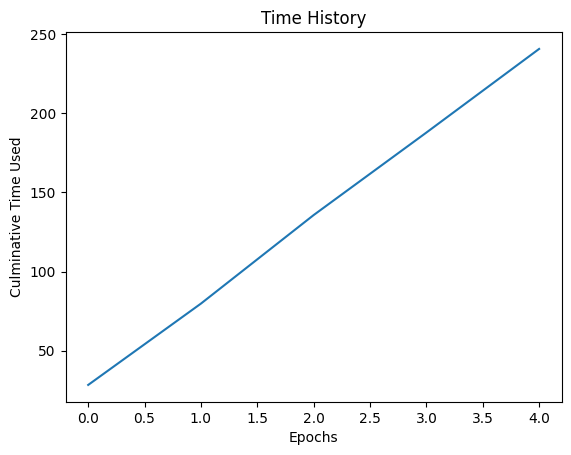

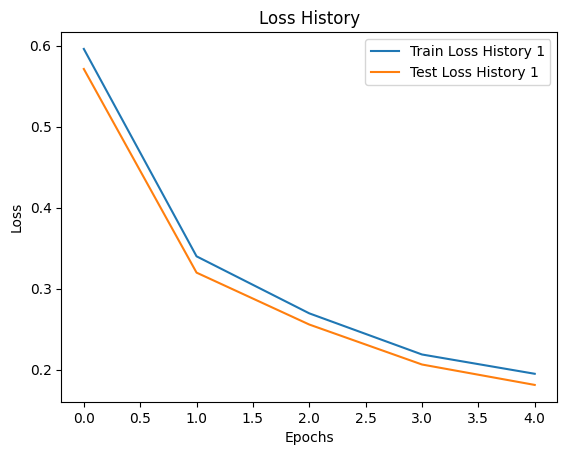

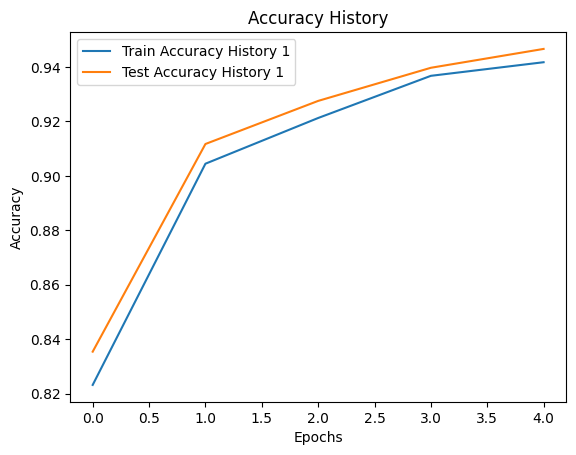

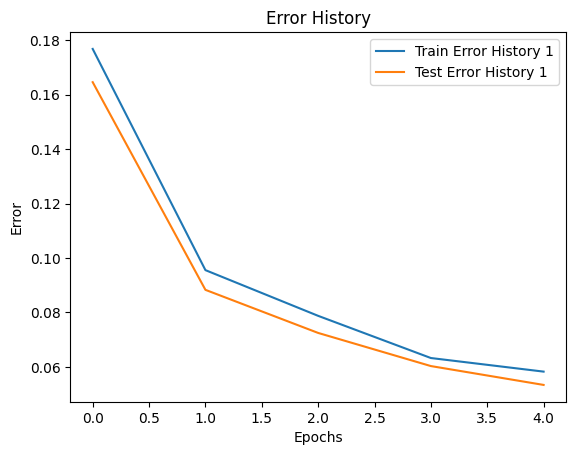

=== The Experiment Result ===
Name of current dataset: MNIST


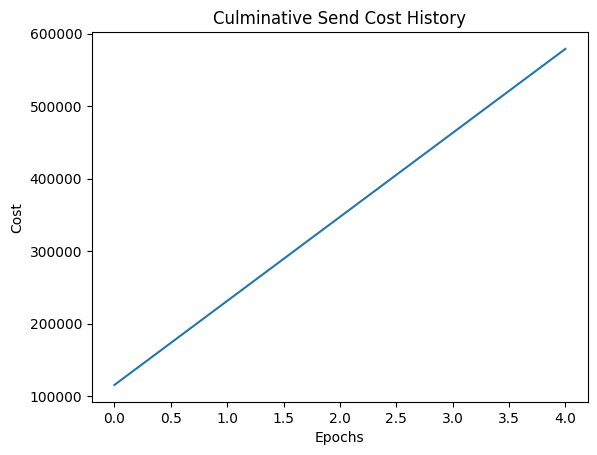

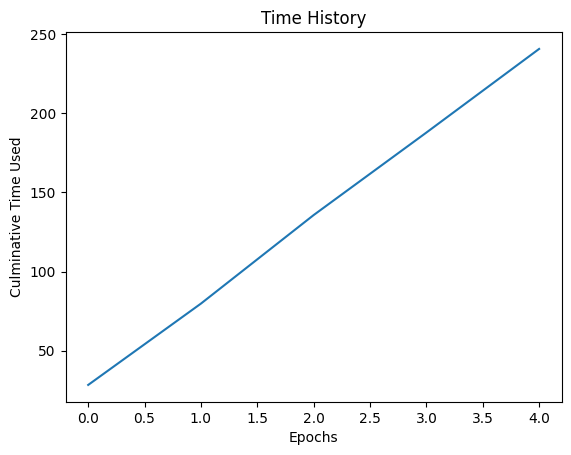

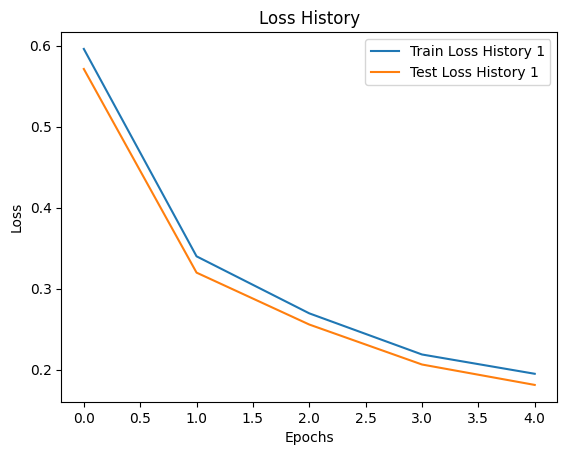

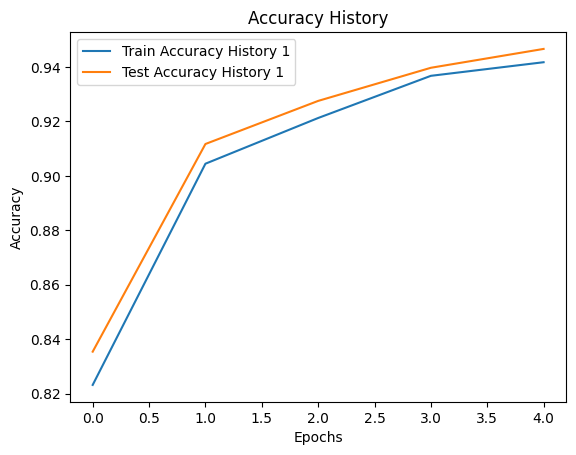

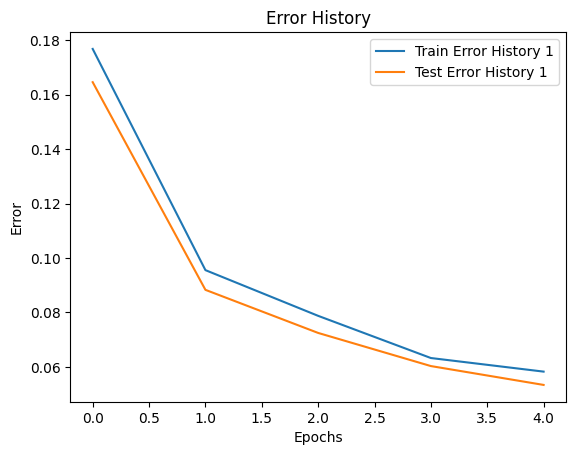

In [14]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple

global_epochs_list = 5
local_epochs_list = 3
num_clients_list = [10]
learning_rate_list = 0.02
batch_size_list = 128
straggler_list = 4
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

random_local_epoch = False
compare_id = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, random_local_epoch, compare_id)

**Experiment: Compare Number of Clients**

The current dataset is MNIST.
The current train start time is 2024-01-14 18.09.29.
=== The training for num_clients is 10 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[-1.4851e-02, -9.1855e-02,  1.3260e-02, -1.1529e-01,  8.9006e-03],
          [ 1.9109e-01,  4.5887e-02, -1.5345e-01,  8.2272e-02, -1.1942e-01],
          [-3.3598e-02, -6.7544e-02, -3.3168e-02, -1.0825e-01,  1.7616e-01],
          [ 9.6009e-02,  9.8364e-02,  1.5066e-01,  1.8828e-01, -5.6294e-02],
          [ 1.2445e-01,  1.1895e-01, -1.4207e-01,  6.8818e-02,  2.5751e-02]]],


        [[[-1

Epoch [1/13], Average Loss: 2.2337663173675537, Average Accuracy: 0.3485704660415649, Average Error: 0.6514295339584351, Culminative Time Used: 3.498347599990666
Epoch [2/13], Average Loss: 1.6964030265808105, Average Accuracy: 0.6208681464195251, Average Error: 0.3791318535804749, Culminative Time Used: 6.6101062999805436
Epoch [3/13], Average Loss: 0.8310728073120117, Average Accuracy: 0.7644614577293396, Average Error: 0.2355385571718216, Culminative Time Used: 9.5222189000051
Epoch [4/13], Average Loss: 0.5976216197013855, Average Accuracy: 0.8137823343276978, Average Error: 0.1862176954746246, Culminative Time Used: 12.821160399995279
Epoch [5/13], Average Loss: 0.4590156972408295, Average Accuracy: 0.8633168935775757, Average Error: 0.1366831362247467, Culminative Time Used: 16.134694299980765
Epoch [6/13], Average Loss: 0.3910649120807648, Average Accuracy: 0.8812927603721619, Average Error: 0.1187072545289993, Culminative Time Used: 19.596048999985214
Epoch [7/13], Average Loss

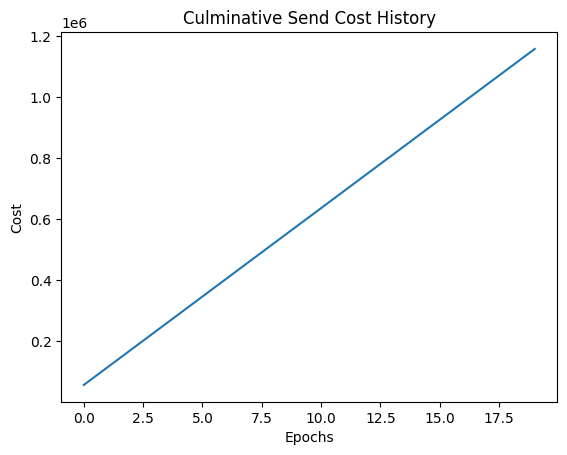

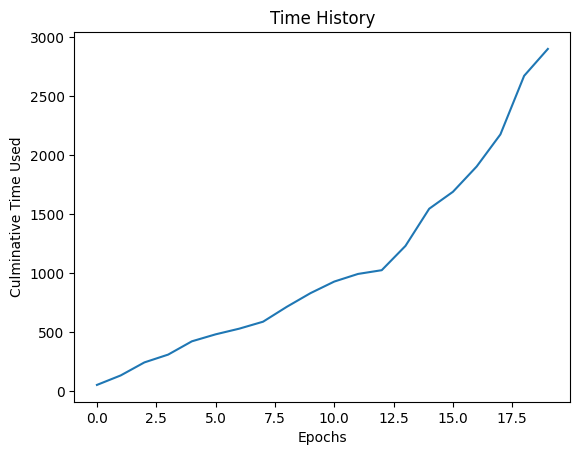

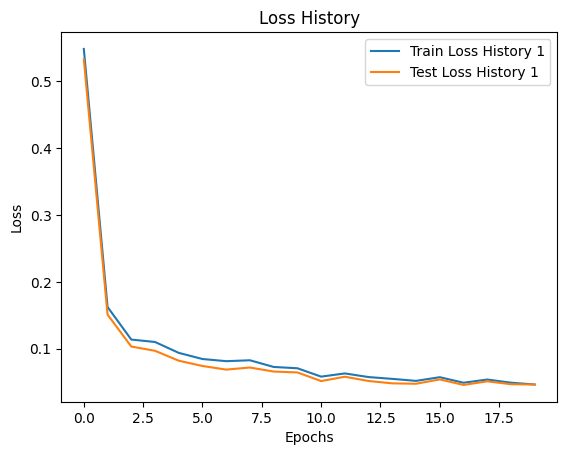

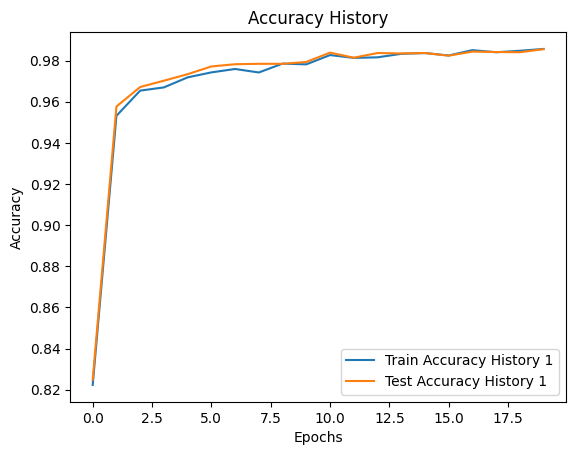

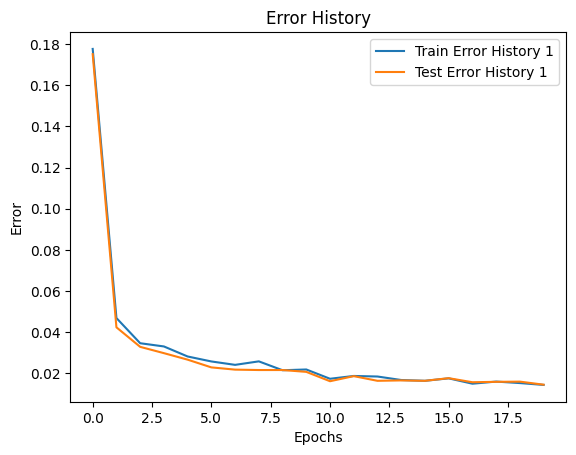

=== The Experiment Result ===
Name of current dataset: MNIST


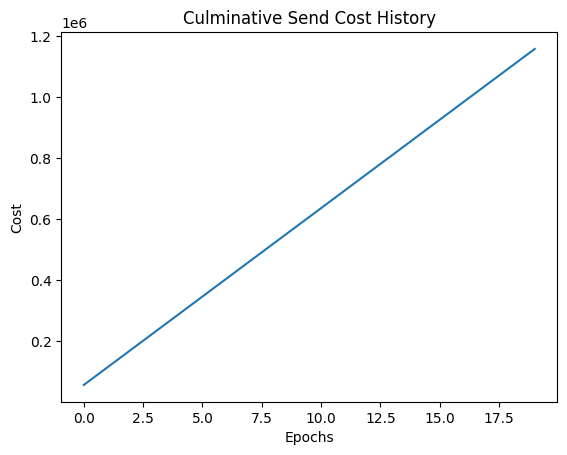

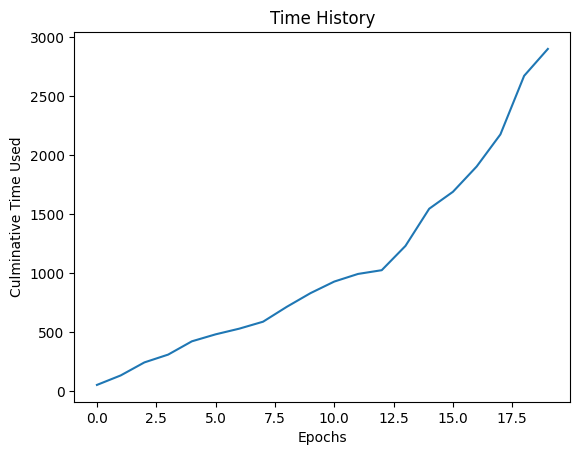

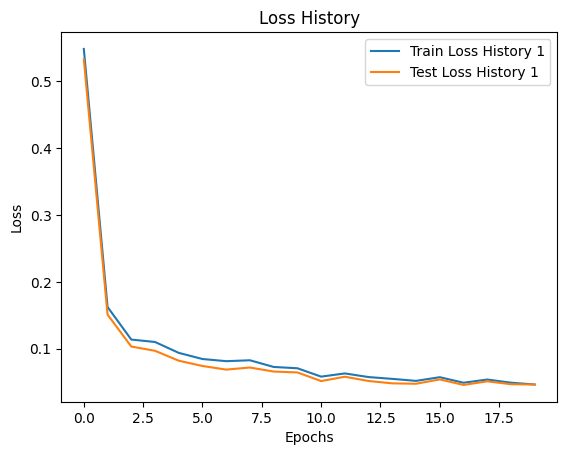

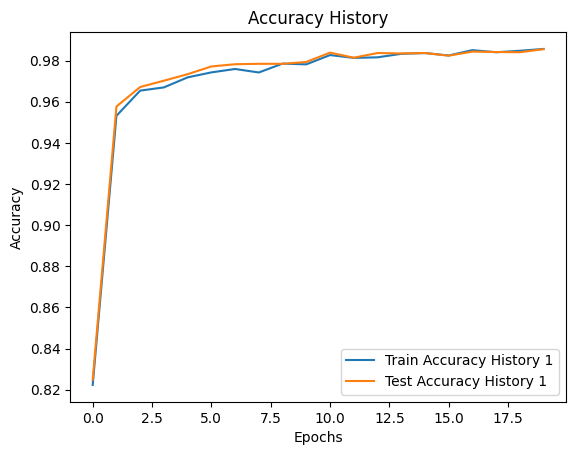

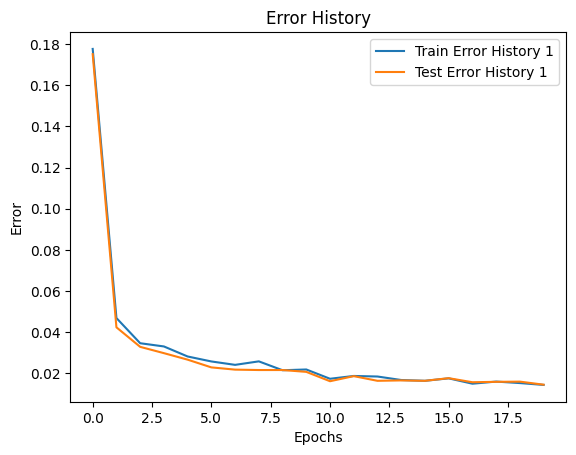

In [13]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
loss_func = loss_func_preset

global_epochs_list = 20
local_epochs_list = 20
num_clients_list = [10]
learning_rate_list = 0.02
batch_size_list = 128
straggler_list = 2
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

random_local_epoch = True
compare_id = 3

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, random_local_epoch, compare_id)

**Experiment: Compare Learning Rate**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
loss_func = loss_func_preset

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10]
learning_rate_list = [0.01, 0.1, 1.0]
batch_size_list = 128
straggler_list = num_clients_list[0]
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

random_local_epoch = False
compare_id = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, random_local_epoch, compare_id)

**Experiment: Compare Batch Size**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
loss_func = loss_func_preset

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10]
learning_rate_list = 0.02
batch_size_list = [10, 128, 1000]
straggler_list = num_clients_list[0]
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

random_local_epoch = False
compare_id = 5

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, random_local_epoch, compare_id)

**Experiment: Compare Straggler**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
loss_func = loss_func_preset

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10]
learning_rate_list = 0.02
batch_size_list = 128
straggler_list = [straggler_rate(num_clients_list[0], 0.0), straggler_rate(num_clients_list[0], 0.5), straggler_rate(num_clients_list[0], 1.0)]
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

random_local_epoch = False
compare_id = 6

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, random_local_epoch, compare_id)

### Section 2.4 FedProx Federated Learning Experiments ###

Note that, compare_id represents:

1: compare global epochs

2: compare local epochs

3: compare number of clients

4: compare learning rate

5: compare batch size

6: compare straggler

7: compare the aggregate weight algorithms

8: compare loss function

9: compare accuracy function

10: compare error function

11: compare mu value

Others: compare global epochs

**Experiment: Compare Local Update Epochs**

In [77]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
loss_func = loss_func_preset

global_epochs_list = 10
local_epochs_list = [3, 5]
num_clients_list = [10]
learning_rate_list = 0.02
batch_size_list = 128
straggler_list = num_clients_list[0]
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
mu_list = 0.01

random_local_epoch = False
compare_id = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, mu_list, random_local_epoch, compare_id)

The current dataset is MNIST.
The current train start time is 2024-01-14 21.16.08.
=== The training for local_epochs is 3 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[-1.7435e-01,  1.8678e-02,  1.0483e-01,  6.9858e-02, -1.9780e-01],
          [-1.8148e-01, -1.6435e-01, -4.5617e-02, -1.8776e-02, -1.9263e-02],
          [-1.0116e-01, -1.6840e-02, -7.6316e-02, -1.5614e-01, -3.1282e-02],
          [ 1.8851e-02,  1.5774e-01, -1.3135e-01,  6.8053e-02,  1.8387e-01],
          [ 7.6841e-02, -1.0949e-01, -1.9917e-02, -8.2220e-02,  3.2495e-02]]],


        [[[-3

RuntimeError: Tensors must have same number of dimensions: got 4 and 1

**Experiment: Compare Number of Clients**

**Experiment: Compare Learning Rate**

**Experiment: Compare Batch Size**

**Experiment: Compare Straggler**

**Experiment: Compare Mu Value**

The current dataset is MNIST.
The current train start time is 2024-01-14 15.07.49.
=== The training for mu is 0.0 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[-1.8601e-01,  6.0537e-02,  6.3965e-02,  9.6018e-02, -1.9374e-01],
          [ 1.4883e-01, -1.3069e-01,  3.9075e-02, -4.9001e-02, -2.4156e-02],
          [-9.4621e-03, -8.2343e-02, -1.6327e-01, -9.8098e-02,  9.9493e-02],
          [-1.6495e-01,  6.2533e-02,  1.2435e-01, -7.2581e-02,  6.1682e-02],
          [ 1.2205e-01, -3.7620e-02, -5.1806e-02,  1.8028e-01, -9.3627e-03]]],


        [[[-7.2083e-0

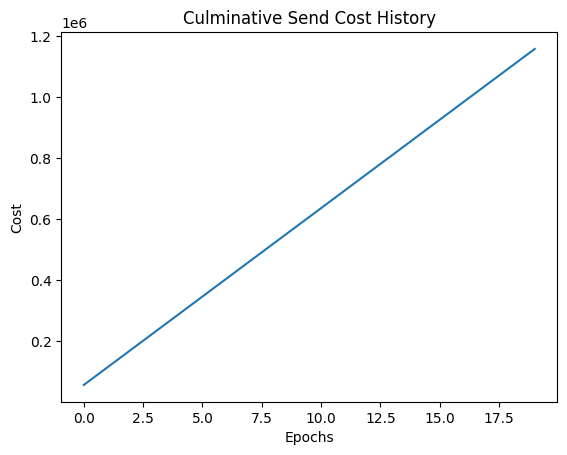

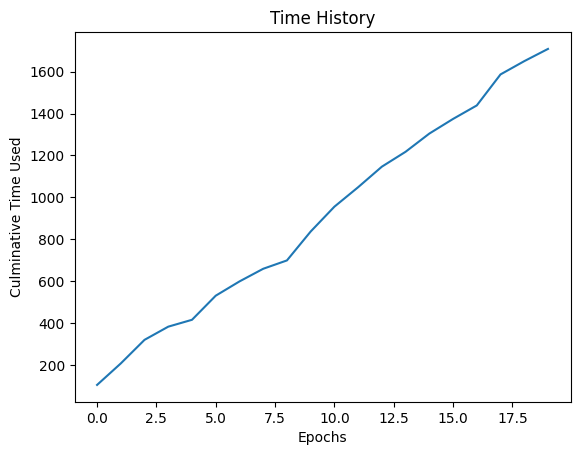

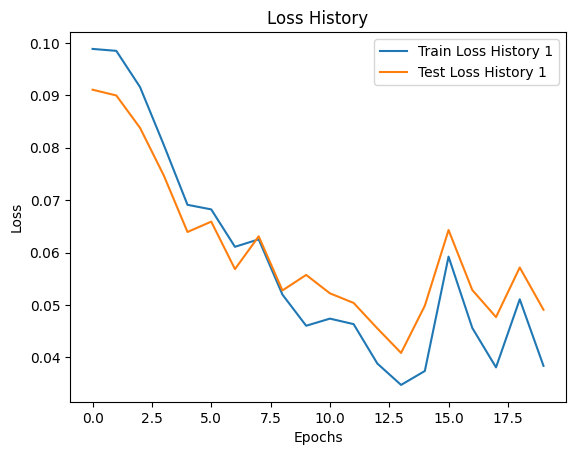

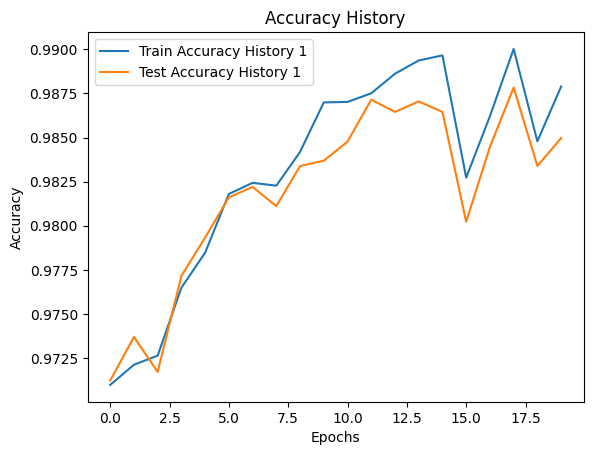

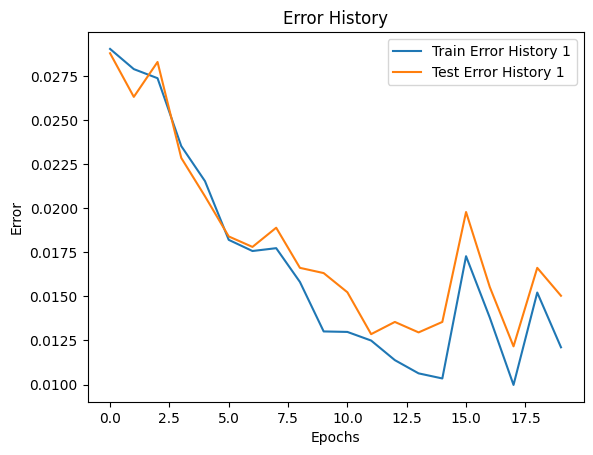

=== The training for mu is 0.1 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[-1.1258e-02, -1.1454e-01,  1.4326e-01,  2.7017e-02,  1.2169e-01],
          [-5.3768e-02, -1.3107e-01,  1.6818e-02,  6.0386e-02,  1.2119e-01],
          [-1.6715e-01, -1.1676e-01,  1.9263e-01,  8.0680e-03,  3.9491e-02],
          [-6.2018e-02, -1.8830e-01, -1.3103e-01, -1.2685e-01, -1.7293e-01],
          [ 8.4597e-02,  6.0961e-02, -1.5813e-01, -7.2330e-02,  7.0738e-02]]],


        [[[ 9.8998e-02,  1.8171e-01,  9.4362e-02, -1.8580e-01, -5.1396e-02],
          [-1.5336e-01,  3.

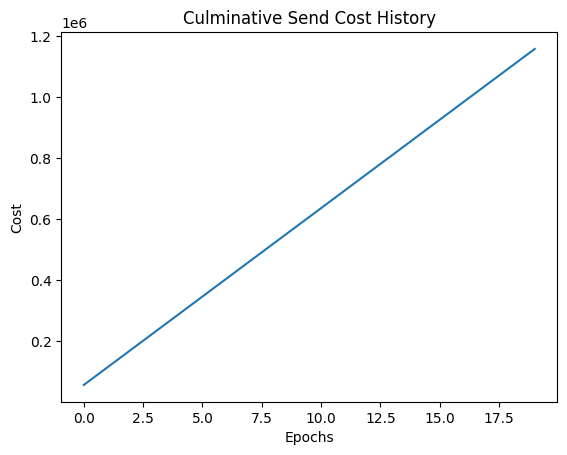

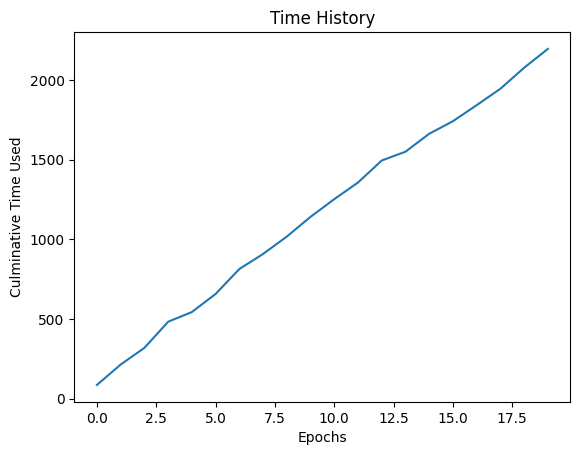

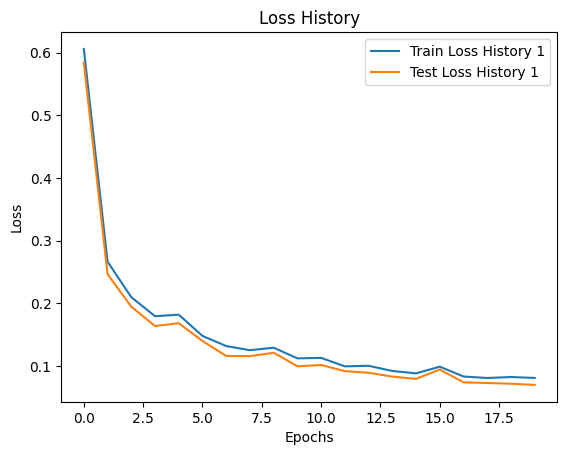

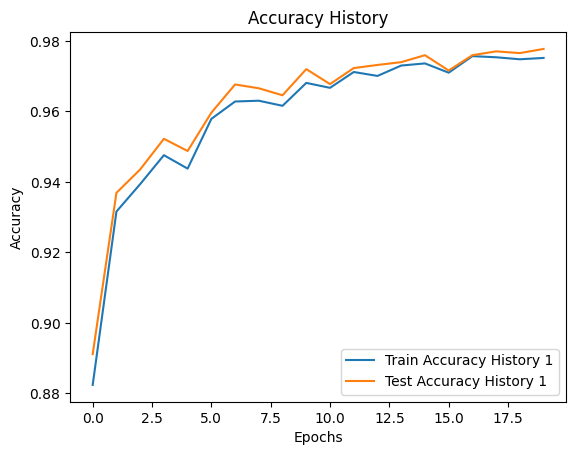

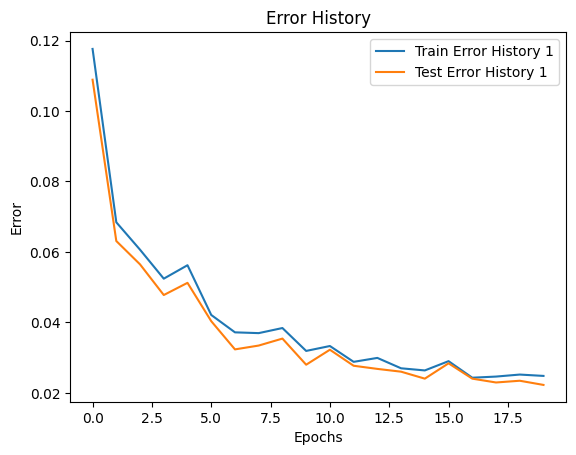

=== The training for mu is 0.5 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[-0.1248, -0.1628,  0.1312, -0.1074, -0.0833],
          [ 0.0817,  0.1726, -0.0039, -0.1134,  0.0922],
          [-0.0536,  0.1783,  0.1450,  0.0830,  0.0315],
          [-0.0595, -0.1984,  0.1355,  0.0807,  0.1620],
          [ 0.1684,  0.1613,  0.0846, -0.1701, -0.1454]]],


        [[[-0.0457, -0.1458,  0.0008,  0.0663, -0.0584],
          [ 0.0492, -0.1162, -0.1969,  0.0205,  0.1204],
          [ 0.1736, -0.1622, -0.0660, -0.0895,  0.0421],
          [ 0.0194,  0.0663,  0.0

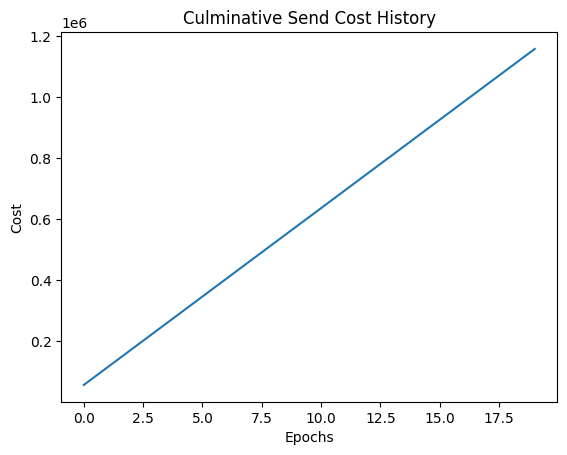

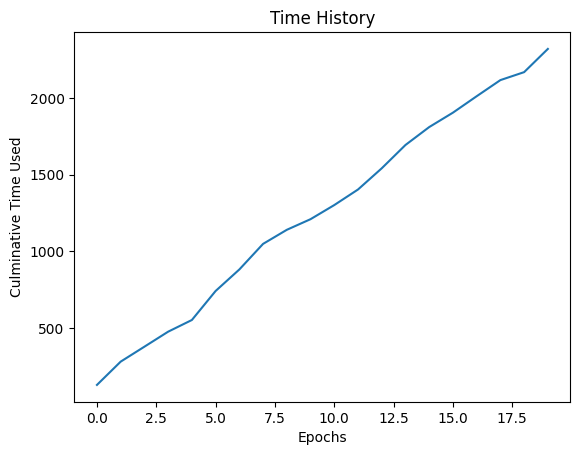

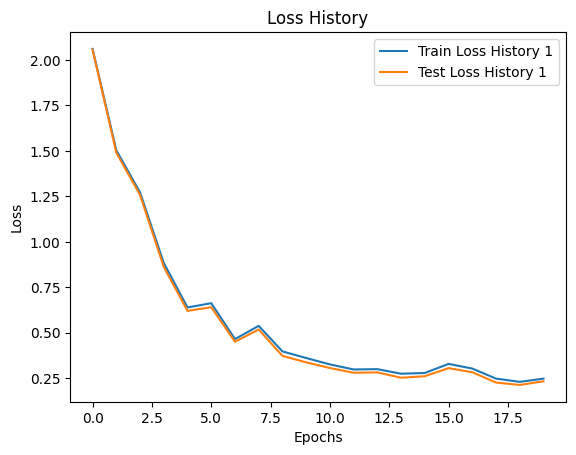

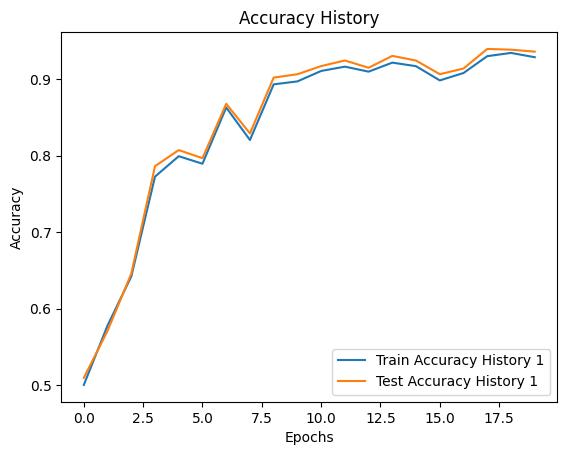

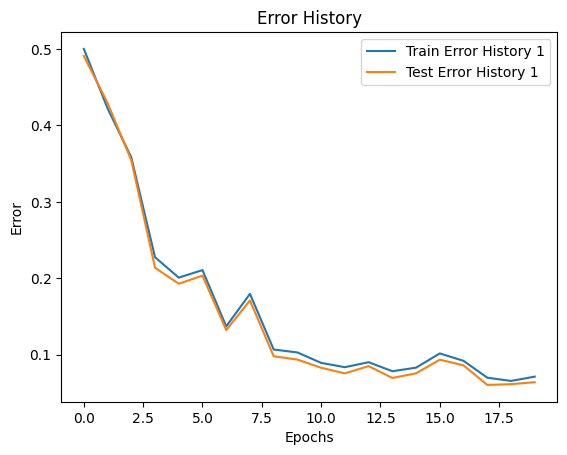

=== The training for mu is 1.0 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[ 1.1620e-01, -6.3153e-02,  1.1102e-01, -2.2059e-02, -1.2146e-01],
          [-1.5859e-01, -1.9116e-01, -1.7202e-01, -1.5447e-01, -1.3360e-01],
          [-4.9366e-02,  4.6041e-02,  1.4522e-01,  8.9836e-02,  1.5161e-01],
          [-5.6970e-02,  1.0094e-02,  5.8896e-02, -1.3431e-02, -9.6559e-02],
          [ 6.8303e-02, -1.7144e-01, -2.3039e-02, -1.3723e-01,  1.8643e-01]]],


        [[[-4.6907e-02, -9.5761e-02, -7.3053e-02,  1.0065e-01, -1.1900e-01],
          [ 1.5861e-01, -1.

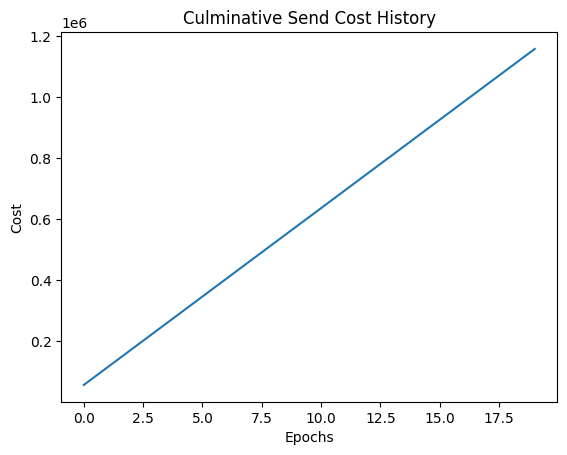

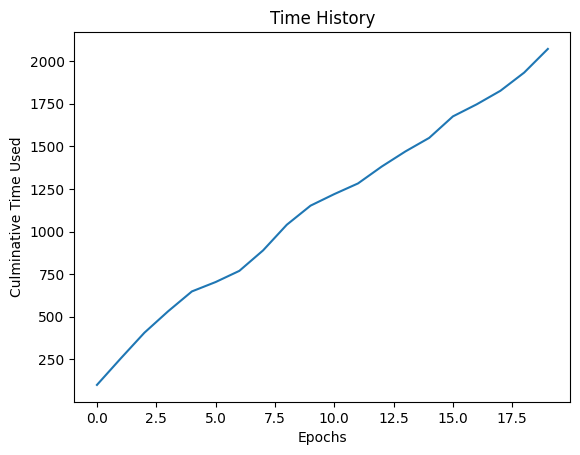

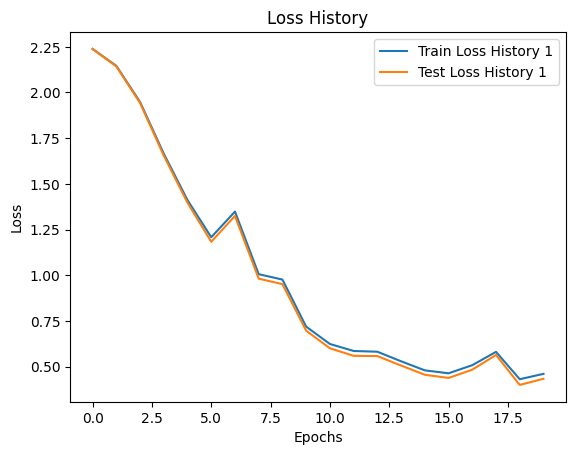

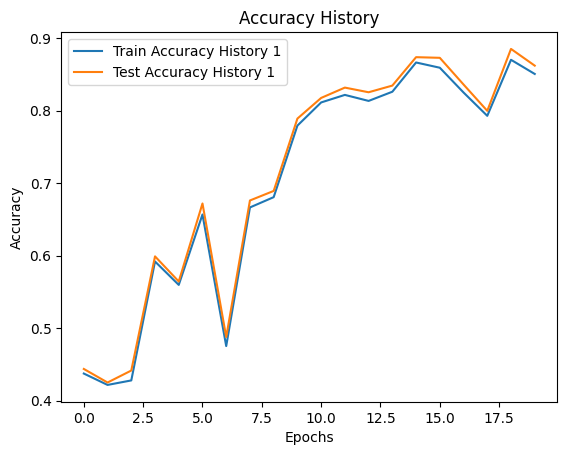

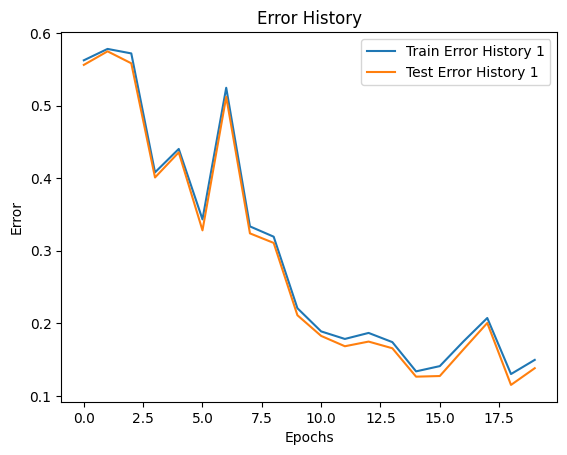

=== The Experiment Result ===
Name of current dataset: MNIST


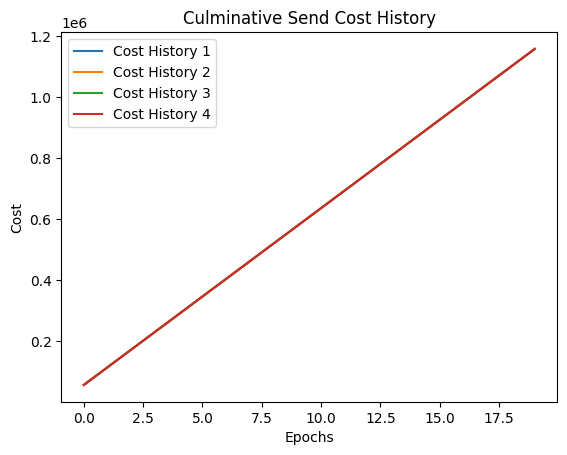

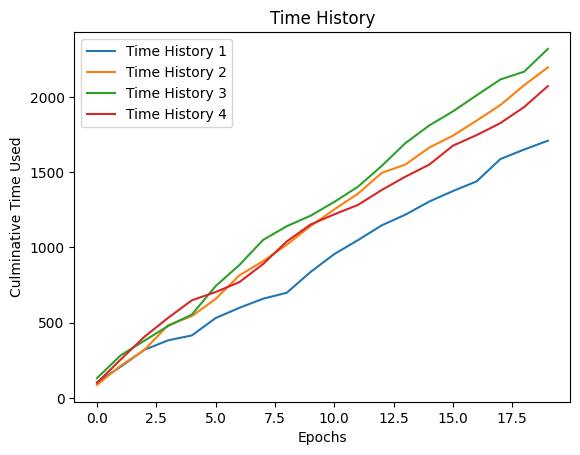

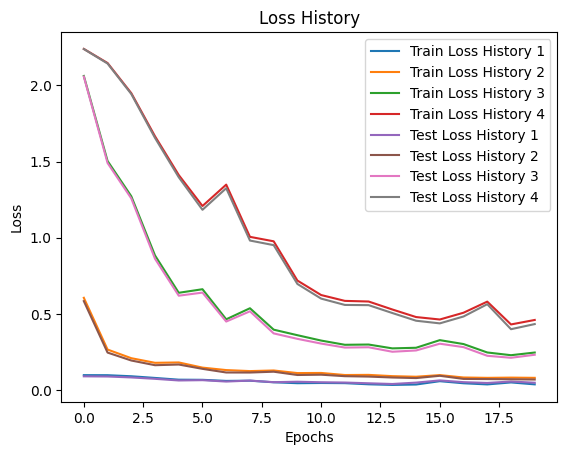

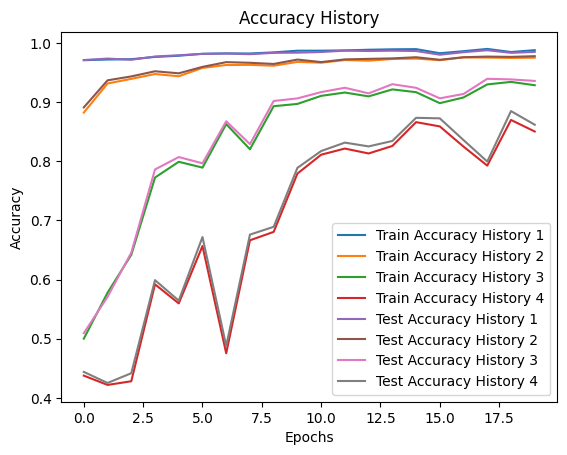

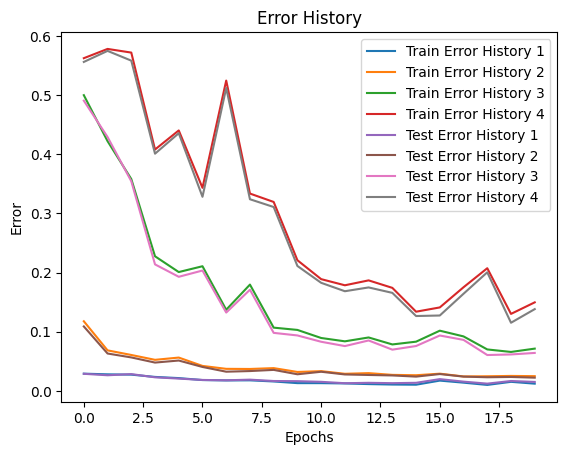

In [11]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
loss_func = loss_func_preset

global_epochs_list = 20
local_epochs_list = 20
num_clients_list = [10]
learning_rate_list = 0.1
batch_size_list = 128
straggler_list = 2
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
mu_list = [0.0, 0.1, 0.5, 1.0]

random_local_epoch = True
compare_id = 11

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, straggler_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, mu_list, random_local_epoch, compare_id)

## Section 3 Analysis ##

#### Section 3.1 Loading Data ####

**Clear and Initialize Data**

In [30]:
data_cost_history_total = []
data_time_history_total = []
data_train_loss_history_total = []
data_train_accuracy_history_total = []
data_train_error_history_total = []
data_test_loss_history_total = []
data_test_accuracy_history_total = []
data_test_error_history_total = []

**Loading Data Manually**

Result has been loaded from the file:  MNIST_FedProx_with_global_epochs_20_local_epochs_20_num_clients_10_batch_size_128_2024-01-13 21.09.40_3.npy
=======Content of the File=======
['cost_history', 'time_history', 'train_loss_history', 'train_accuracy_history', 'train_error_history', 'test_loss_history', 'test_accuracy_history', 'test_error_history']
=======VISUALIZATION RESULT=======


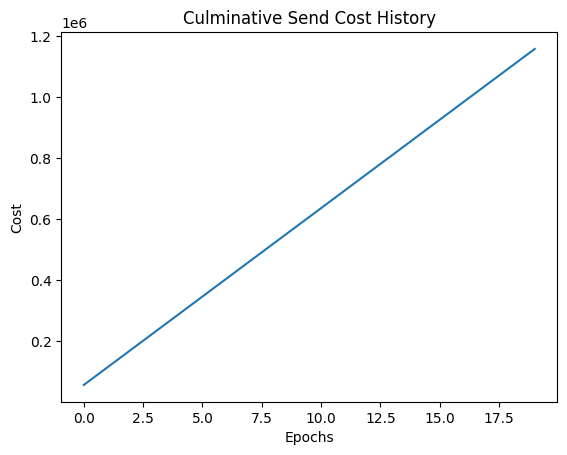

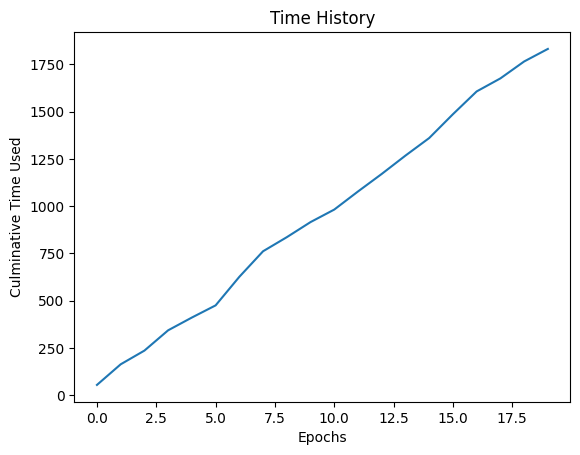

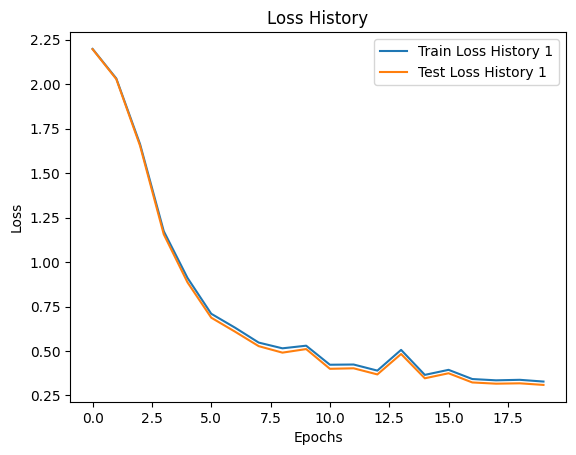

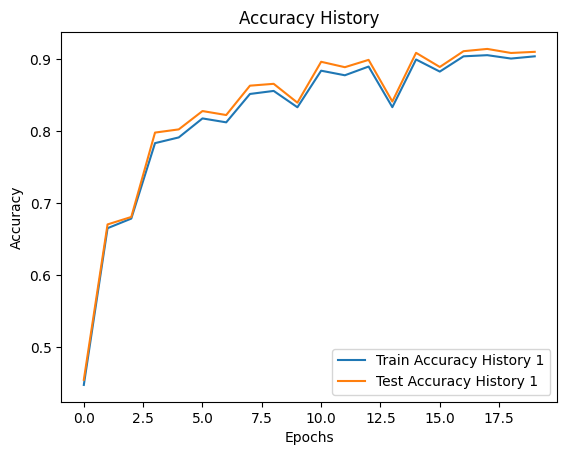

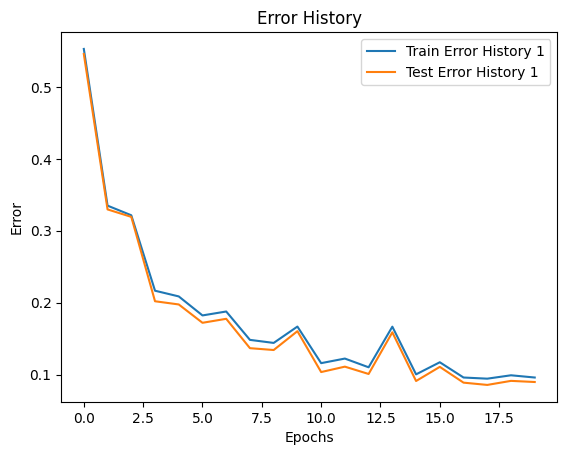

=======STATUS RESULT=======
Cost History:  [  57876.  115752.  173628.  231504.  289380.  347256.  405132.  463008.
  520884.  578760.  636636.  694512.  752388.  810264.  868140.  926016.
  983892. 1041768. 1099644. 1157520.]
Time History:  [  55.0727922  164.0955189  236.5298404  343.890347   411.3639396
  475.6382273  626.7104381  761.8604106  836.2624283  916.0418103
  982.2617792 1077.9312491 1170.6656746 1267.6303192 1360.449678
 1486.4111623 1606.9208107 1675.8227345 1765.2301957 1831.6503753]
=======TRAIN RESULT=======
Train Loss History:  [2.19753647 2.03135443 1.66268742 1.1732688  0.9106639  0.70923334
 0.63123393 0.54723775 0.51500589 0.52975357 0.42272013 0.42399302
 0.38975221 0.50621647 0.36570907 0.39404574 0.34239542 0.33515325
 0.3380177  0.32822725]
Train Accuracy History:  [0.44701713 0.66505635 0.67843258 0.78338778 0.79133356 0.81778049
 0.81231678 0.85179013 0.85603237 0.83328331 0.88416177 0.87779289
 0.88992536 0.83342218 0.89974785 0.88292348 0.90415114 0.9057

In [35]:
# Change these variables manually here!!
load_dataset_name = "MNIST"
load_aggreagte_func = "FedProx"
load_global_epochs = 20
load_local_epochs = 20
load_num_clients = 10
load_batch_size = 128
load_train_start_time = "2024-01-13 21.09.40"
load_experiment_id = 3
data_append_load = True

# Load the file
filename_load = "{}_{}_with_global_epochs_{}_local_epochs_{}_num_clients_{}_batch_size_{}_{}_{}.npy".format(load_dataset_name, load_aggreagte_func, load_global_epochs, load_local_epochs, load_num_clients, load_batch_size, load_train_start_time, load_experiment_id)
load_result = np.load(filename_load)
print('Result has been loaded from the file: ', filename_load)

# Load the attributes from the file
data_cost_history = load_result['cost_history']
data_time_history = load_result['time_history']
data_train_loss_history = load_result['train_loss_history']
data_train_accuracy_history = load_result['train_accuracy_history']
data_train_error_history = load_result['train_error_history']
data_test_loss_history = load_result['test_loss_history']
data_test_accuracy_history = load_result['test_accuracy_history']
data_test_error_history = load_result['test_error_history']

print("=======Content of the File=======")
print(load_result.files)

print("=======VISUALIZATION RESULT=======")
plot_cost_history([data_cost_history], save=False)
plot_time_history([data_time_history], save=False)
plot_loss_history([data_train_loss_history], [data_test_loss_history], save=False)
plot_accuracy_history([data_train_accuracy_history], [data_test_accuracy_history], save=False)
plot_error_history([data_train_error_history], [data_test_error_history], save=False)

print("=======STATUS RESULT=======")
print("Cost History: ", data_cost_history)
print("Time History: ", data_time_history)

print("=======TRAIN RESULT=======")
print("Train Loss History: ", data_train_loss_history)
print("Train Accuracy History: ", data_train_accuracy_history)
print("Train Error History: ", data_train_error_history)

print("=======TEST RESULT=======")
print("Test Loss History: ", data_test_loss_history)
print("Test Accuracy History: ", data_test_accuracy_history)
print("Test Error History: ", data_test_error_history)

# Append the data
if data_append_load:
    data_cost_history_total.append(data_cost_history)
    data_time_history_total.append(data_time_history)
    data_train_loss_history_total.append(data_train_loss_history)
    data_train_accuracy_history_total.append(data_train_accuracy_history)
    data_train_error_history_total.append(data_train_error_history)
    data_test_loss_history_total.append(data_test_loss_history)
    data_test_accuracy_history_total.append(data_test_accuracy_history)
    data_test_error_history_total.append(data_test_error_history)

**Loading Data Using Loop**

In [ ]:
# Change these variables manually here!!
# load_loop_max correspond to number of files you want to load
load_dataset_name_list = ["MNIST"]
load_aggreagte_func_list = ["FedAvg"]
load_global_epochs_list = [2]
load_local_epochs_list = [1]
load_num_clients_list = [2]
load_batch_size_list = [128]
load_train_start_time_list = ["2023-12-04 19.48.18"]
load_loop_max = 1
data_append_load = True

for n in range(load_loop_max):
    # Load the file
    filename_load = "{}_{}_with_global_epochs_{}_local_epochs_{}_num_clients_{}_batch_size_{}_{}.npy".format(load_dataset_name_list[n], load_aggreagte_func_list[n], load_global_epochs_list[n], load_local_epochs_list[n], load_num_clients_list[n], load_batch_size_list[n], load_train_start_time_list[n])
    load_result = np.load(filename_load)
    print('Result has been loaded from the file: ', filename_load)

    # Load the attributes from the file
    data_cost_history = load_result['cost_history']
    data_time_history = load_result['time_history']
    data_train_loss_history = load_result['train_loss_history']
    data_train_accuracy_history = load_result['train_accuracy_history']
    data_train_error_history = load_result['train_error_history']
    data_test_loss_history = load_result['test_loss_history']
    data_test_accuracy_history = load_result['test_accuracy_history']
    data_test_error_history = load_result['test_error_history']

    # Append the data
    if data_append_load:
        data_cost_history_total.append(data_cost_history)
        data_time_history_total.append(data_time_history)
        data_train_loss_history_total.append(data_train_loss_history)
        data_train_accuracy_history_total.append(data_train_accuracy_history)
        data_train_error_history_total.append(data_train_error_history)
        data_test_loss_history_total.append(data_test_loss_history)
        data_test_accuracy_history_total.append(data_test_accuracy_history)
        data_test_error_history_total.append(data_test_error_history)

**Visualize All Data**

In [ ]:
plot_cost_history(data_cost_history_total, save=False)
plot_time_history(data_time_history_total, save=False)
plot_loss_history(data_train_loss_history_total, data_test_loss_history_total, save=False)
plot_accuracy_history(data_train_accuracy_history_total, data_test_accuracy_history_total, save=False)
plot_error_history(data_train_error_history_total, data_test_error_history_total, save=False)

**Experiment between different Local Updates Epochs Graph**

In [ ]:
plot_local_update_epochs_list = [1, 10, 3, 4, 5, 10]

plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with local epochs = {plot_local_update_epochs_list[i]}")
for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
    plt.plot(plot_test_loss_history, label=f"Test Loss History with local epochs = {plot_local_update_epochs_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Loss")
plt.title("Loss History with different local update epochs")
plt.legend()
plt.savefig(f'{current_dataset_name}_loss_history_compare_local_update_epochs_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with local epochs = {plot_local_update_epochs_list[i]}")
for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with local epochs = {plot_local_update_epochs_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different local update epochs")
plt.legend()
plt.savefig(f'{current_dataset_name}_accuracy_history_compare_local_update_epochs_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with local epochs = {plot_local_update_epochs_list[i]}")
for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
    plt.plot(plot_test_error_history, label=f"Test Accuracy History with local epochs = {plot_local_update_epochs_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Error")
plt.title("Error History with different local update epochs")
plt.legend()
plt.savefig(f'{current_dataset_name}_error_history_compare_local_update_epochs_{train_start_time}.png')
plt.show()

**Experiment between different Number of Clients Graph**

In [ ]:
plot_num_clients_list = [1, 5, 10, 20]

plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with number of clients = {plot_num_clients_list[i]}")
for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
    plt.plot(plot_test_loss_history, label=f"Test Loss History with number of clients = {plot_num_clients_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Loss")
plt.title("Loss History with different number of clients")
plt.legend()
plt.savefig(f'{current_dataset_name}_loss_history_compare_number_of_clients_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with number of clients = {plot_num_clients_list[i]}")
for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with number of clients = {plot_num_clients_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different number of clients")
plt.legend()
plt.savefig(f'{current_dataset_name}_accuracy_history_compare_number_of_clients_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with number of clients = {plot_num_clients_list[i]}")
for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
    plt.plot(plot_test_error_history, label=f"Test Accuracy History with number of clients = {plot_num_clients_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Error")
plt.title("Error History with different number of clients")
plt.legend()
plt.savefig(f'{current_dataset_name}_error_history_compare_number_of_clients_{train_start_time}.png')
plt.show()

**Experiment between different Batch Size Graph**

In [ ]:
plot_batch_size_list = [1, 5, 10, 20]

plot_different_time_history = convert_to_list(data_time_history_total)
for i, plot_time_history in enumerate(plot_different_time_history):
    plt.plot(plot_time_history, label=f"Time History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Culminative Time Used")
plt.title("Time History")
plt.legend()
plt.savefig(f'{current_dataset_name}_time_history_compare_batch_size_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with batch size = {plot_batch_size_list[i]}")
for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
    plt.plot(plot_test_loss_history, label=f"Test Loss History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Loss")
plt.title("Loss History with different batch size")
plt.legend()
plt.savefig(f'{current_dataset_name}_loss_history_compare_batch_size_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with batch size = {plot_batch_size_list[i]}")
for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different batch size")
plt.legend()
plt.savefig(f'{current_dataset_name}_accuracy_history_compare_batch_size_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with batch size = {plot_batch_size_list[i]}")
for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
    plt.plot(plot_test_error_history, label=f"Test Accuracy History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Error")
plt.title("Error History with different batch size")
plt.legend()
plt.savefig(f'{current_dataset_name}_error_history_compare_batch_size_{train_start_time}.png')
plt.show()

**Experiment between different Mu Rate Graph**

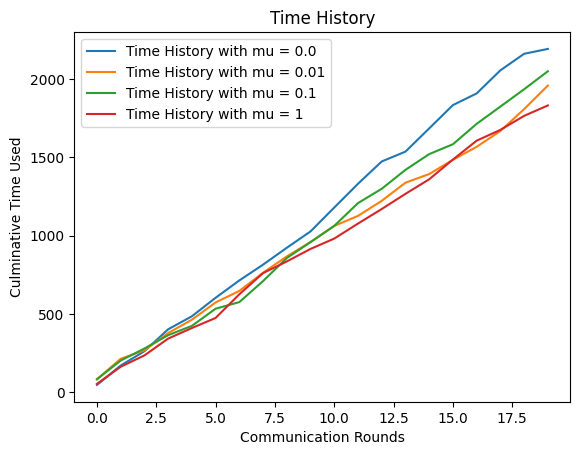

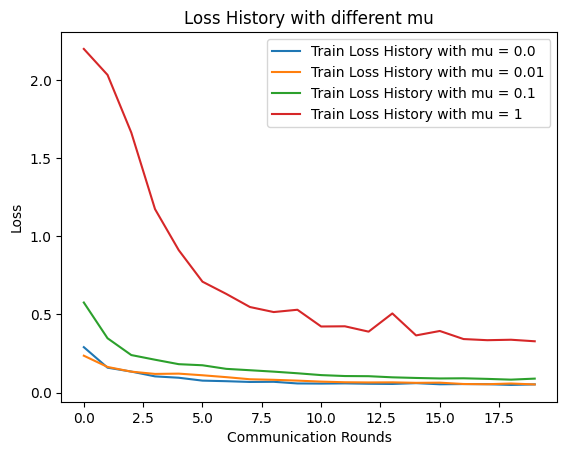

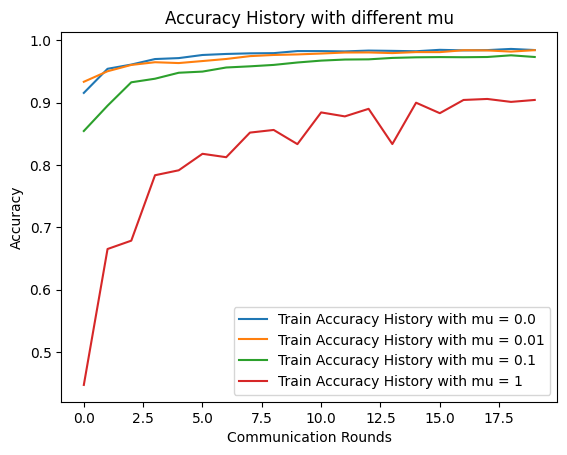

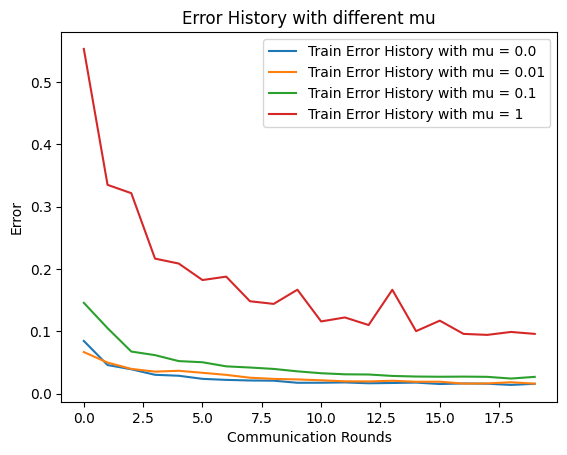

In [36]:
plot_mu_list = [0.00, 0.01, 0.1, 1]

plot_different_time_history = convert_to_list(data_time_history_total)
for i, plot_time_history in enumerate(plot_different_time_history):
    plt.plot(plot_time_history, label=f"Time History with mu = {plot_mu_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Culminative Time Used")
plt.title("Time History")
plt.legend()
plt.savefig(f'{current_dataset_name}_time_history_compare_mu_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with mu = {plot_mu_list[i]}")
#for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
#    plt.plot(plot_test_loss_history, label=f"Test Loss History with mu = {plot_mu_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Loss")
plt.title("Loss History with different mu")
plt.legend()
plt.savefig(f'{current_dataset_name}_loss_history_compare_mu_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with mu = {plot_mu_list[i]}")
#for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
#    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with mu = {plot_mu_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different mu")
plt.legend()
plt.savefig(f'{current_dataset_name}_accuracy_history_compare_mu_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with mu = {plot_mu_list[i]}")
#for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
#    plt.plot(plot_test_error_history, label=f"Test Accuracy History with mu = {plot_mu_list[i]}")
plt.xlabel("Communication Rounds")
plt.ylabel("Error")
plt.title("Error History with different mu")
plt.legend()
plt.savefig(f'{current_dataset_name}_error_history_compare_mu_{train_start_time}.png')
plt.show()

**Experiment between different Federated Learning Framework**

#### Section 3.2 Analysing ####

**Variance Analysis**

We analysis the variance of a particular file.

In [ ]:
cost_variance = statistics.variance(data_cost_history)
time_variance = statistics.variance(data_time_history)
train_loss_variance = statistics.variance(data_train_loss_history)
train_accuracy_variance = statistics.variance(data_train_accuracy_history)
train_error_variance = statistics.variance(data_train_error_history)
test_loss_variance = statistics.variance(data_test_loss_history)
test_accuracy_variance = statistics.variance(data_test_accuracy_history)
test_error_variance = statistics.variance(data_test_error_history)
print("=======VARIANCE RESULT=======")
print("Cost Variance: ", cost_variance)
print("Time Variance: ", time_variance)
print("Train Loss Variance: ", train_loss_variance)
print("Train Accuracy Variance: ", train_accuracy_variance)
print("Train Error Variance: ", train_error_variance)
print("Test Loss Variance: ", test_loss_variance)
print("Test Accuracy Variance: ", test_accuracy_variance)
print("Test Error Variance: ", test_error_variance)

In [ ]:
cost_variance_subset = statistics.variance(data_cost_history[:len(data_cost_history) // 2])
time_variance_subset = statistics.variance(data_time_history[:len(data_time_history) // 2])
train_loss_variance_subset = statistics.variance(data_train_loss_history[:len(data_train_loss_history) // 2])
train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[:len(data_train_accuracy_history) // 2])
train_error_variance_subset = statistics.variance(data_train_error_history[:len(data_train_error_history) // 2])
test_loss_variance_subset = statistics.variance(data_test_loss_history[:len(data_test_loss_history) // 2])
test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[:len(data_test_accuracy_history) // 2])
test_error_variance_subset = statistics.variance(data_test_error_history[:len(data_test_error_history) // 2])
print("=======VARIANCE FIRST SUBSET RESULT=======")
print("Cost Variance in Subset: ", cost_variance_subset)
print("Time Variance in Subset: ", time_variance_subset)
print("Train Loss Variance in Subset: ", train_loss_variance_subset)
print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
print("Train Error Variance in Subset: ", train_error_variance_subset)
print("Test Loss Variance in Subset: ", test_loss_variance_subset)
print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
print("Test Error Variance in Subset: ", test_error_variance_subset)

In [ ]:
cost_variance_subset = statistics.variance(data_cost_history[len(data_cost_history) // 2:])
time_variance_subset = statistics.variance(data_time_history[len(data_time_history) // 2:])
train_loss_variance_subset = statistics.variance(data_train_loss_history[len(data_train_loss_history) // 2:])
train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[len(data_train_accuracy_history) // 2:])
train_error_variance_subset = statistics.variance(data_train_error_history[len(data_train_error_history) // 2:])
test_loss_variance_subset = statistics.variance(data_test_loss_history[len(data_test_loss_history) // 2:])
test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[len(data_test_accuracy_history) // 2:])
test_error_variance_subset = statistics.variance(data_test_error_history[len(data_test_error_history) // 2:])
print("=======VARIANCE LAST SUBSET RESULT=======")
print("Cost Variance in Subset: ", cost_variance_subset)
print("Time Variance in Subset: ", time_variance_subset)
print("Train Loss Variance in Subset: ", train_loss_variance_subset)
print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
print("Train Error Variance in Subset: ", train_error_variance_subset)
print("Test Loss Variance in Subset: ", test_loss_variance_subset)
print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
print("Test Error Variance in Subset: ", test_error_variance_subset)